# Processing Tabular Data with Dask DataFrames: an End-to-End Example


## Outline
1. When and Why You Should Use Dask DataFrames
   - Dask scales all components of your typical tabular data processing pipeline. It’s versatile. 
   - This means you can now process datasets comfortably without worrying about dataset size. More data generally means better insights...if you can crunch it well and in time.
   - We’ve built an end-to-end example that showcases common components and how Dask plugs into it.
   

2. Get Data
   - Read in large dataset into Pandas DataFrame, errors out
   - Read from CSV with Dask
   - Write data to Parquet / S3
   - Read data back in with from_parquet


3. Discover the Data for Quality-Check
   - Take a Quick Look at the Data Structure
   - Use common Pandas syntax to perform EDA
       - Summary statistics / describe
       - Groupby
       
4. Data Cleaning
    - Use common Pandas syntax to clean data


5. Visualize the Data to Gain Insights
    - Considerations when plotting such large datasets
        - Reduce to in-memory dataset and use matplotlib/seaborn/whatever
        - Plot large datasets with tools like datashader


6. Joining DataFrames
    - Read semi-structured JSON into Dask Bag
    - Flatten and write to Dask DataFrame
    - Join to large DataFrame
    

7. Train an XGBoost model
    - Create train/test splits
    - Train model
    - Evaluate
    
    
9. Tune your model with GridSearchCV


10. Present your Solution


11. Try it out!

## 1. Look at the Big Picture
Imagine you're a data scientist working for the Government of New York City. You have been crunching data and delivering value for this organisation for years using pandas, but data volumes are increasing rapidly and you and your teammates are experiencing bottlenecks caused by pandas' single-core limitations. 

You love having access to more date because it generally means better insights...but only if your team can deliver results within reasonable timeframes. Sitting around for hours waiting for a pandas operation to run, only to finally error out with a MemoryError is not the best use of your time in this demanding work environment.

You've recently heard about Dask and how it can solve these scalability issues for you with minimal friction. Dask DataFrame scales all the components of your typical tabular data processing pipeline, using familiar pandas syntax. This means you can use Dask DataFrame to process datasets comfortably without worrying about dataset size. And unlike other big data solutions, you and your team don't need to spend weeks learning a new syntax.

In this chapter, you’ll work through an end-to-end example of processing tabular data at scale. Here are the main steps you will go through:

1. Look at the Big Picture
2. Get the Data
3. Discover the Data and Assess Quality
4. Visualize the Data to Get Insights
5. Clean the Data
6. Join Multiple Datasets
7. Train a Machine Learning Model on the Data
8. Evaluate and Tune the Model
9. Present the solution

*This chapter explicitly focuses on the practical implementation and value-add of using Dask DataFrame and will include only minimal explanations of key concepts. For a more in-depth of the architecture behind Dask DataFrame and fundamental distributed computing concepts, refer to Chapters 3 and 4.*

## Working with Real Data 
It's best to work with real data when you're learning new technologies, and not just artificial datasets. This allows you to experience first-hand the power of a new technology in solving real-world problems.

In this chapter we'll be working with the New York City Taxi and Limousine Commission (TLC) Trip Record dataset. We'll start by working with the dataset for the year 2012 which contains more tha 178 million records of NYC's yellow taxi cab trips, for a total size of ~25GB. From there, we will scale our processing pipeline up to work with the dataset for the 5-year period between 2009 and 2013, containing more than 868 million rows of data, for a total size of ~120GB on disk. Most personal computers on the market today will have trouble loading this dataset entirely into memory, so this will make for a great case to demonstrate the power of Dask DataFrames.

As you work through this chapter, keep these 3 things in mind:
- Dask DataFrame scales pandas to **larger-than-memory datasets**
- Dask DataFrame **copies the pandas syntax** wherever possible
- Dask DataFrame distributes data processing over **multiple cores**

Here are some places you can go to find other datasets to work with:
- 1
- 2
- 3

### Frame the Problem
Your specific commission for this project is to assist the NYC TLC in a campaign to boost morale amongst its drivers. Since the launch of rideshare companies in NYC in [2011](https://www.businessinsider.com/what-is-uber-tour-new-york-city?international=true&r=US&IR=T), the number of taxi cabs fares has dropped by ~75% and the TLC is struggling with a massive exit of employees. To motivate drivers, the TLC wants to give drivers information on how to increase the probability of a high tip. We'll start by working with the data for a single year (2013) and then quickly scale up to look at 10 years worth of data. 

Most reports agree that, even though they were launched earlier, rideshare platforms really began to eat away at the yellow cab ridership in [2014](https://nypost.com/2021/10/30/uber-lyft-ridership-falls-15-in-nyc-taxi-cab-trips-rise/). Your goal will be to analyse differences between the 5-year periods before and after the introduction of rideshare tech in the NYC transportation sector.

Questions:
- Is there a significant decrease in the number of yellow cab trips in the years since 2014?
  - Can we show this in more detail by month/week (timeseries)?
- 


#### Sources
"New Yorkers once took about half a million taxi trips per day — until 2014, when Uber and Lyft began to eat away at taxi ridership."([source](https://nypost.com/2021/10/30/uber-lyft-ridership-falls-15-in-nyc-taxi-cab-trips-rise/))

[Graph](https://www.marketwatch.com/story/this-chart-shows-how-uber-rides-sped-past-nyc-yellow-cabs-in-just-six-years-2019-08-09)

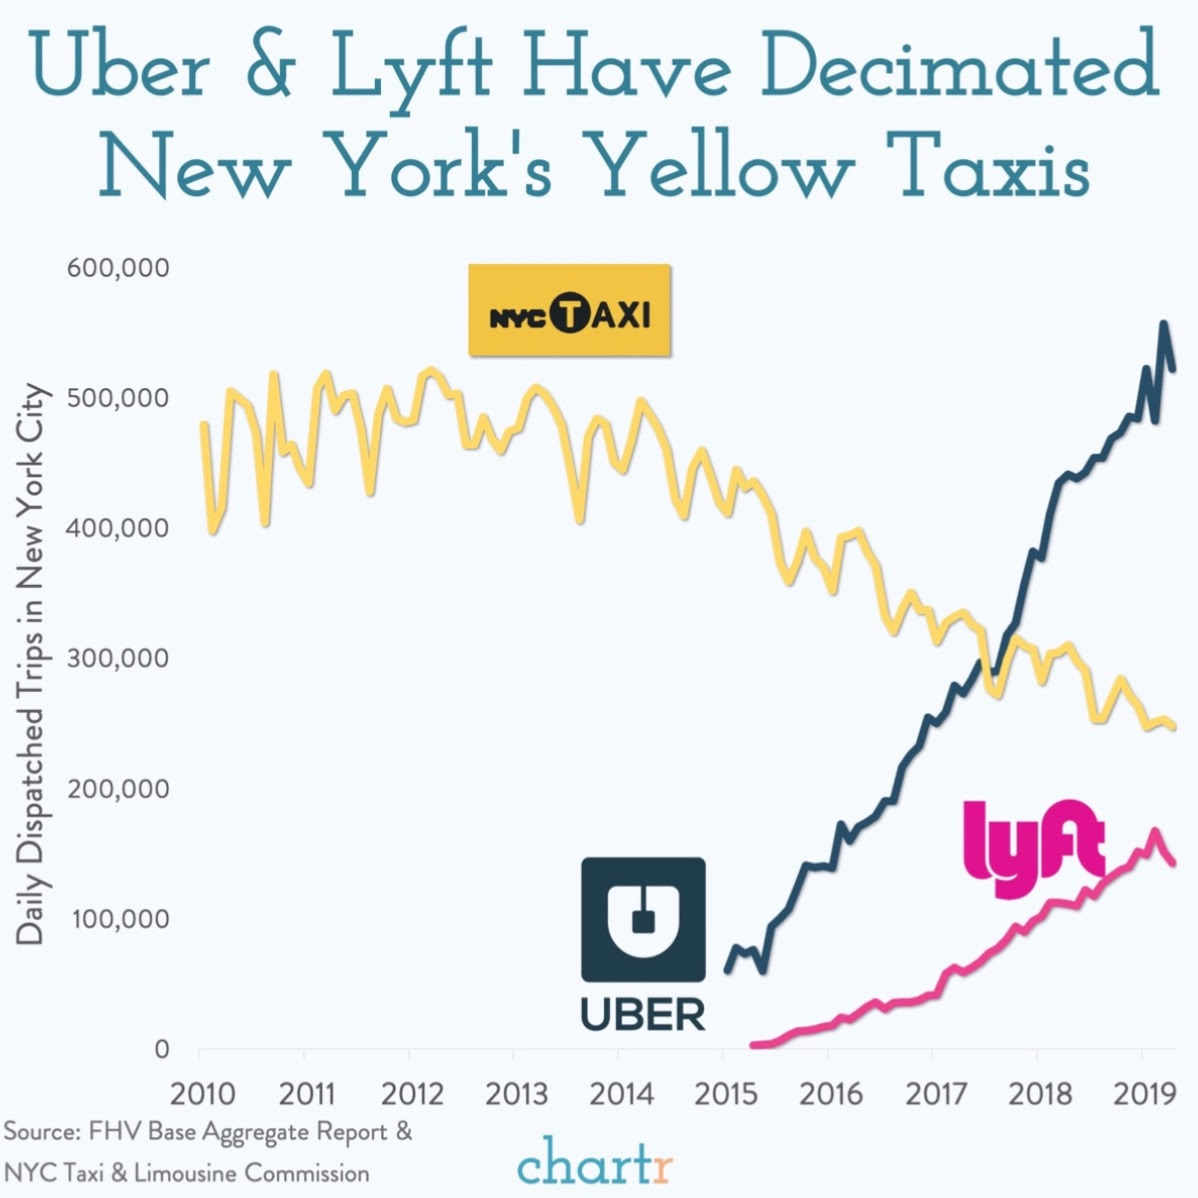

## Running Dask in the Cloud
In this imaginary scenario, the Government of New York has prioritised data innovation and developer experience. They have given the entire Data Unit access to cloud computing resources to speed up your data processing. 

Spin up Coiled cluster.

In [ ]:
# import coiled

# coiled.create_software_environment(
#     account="coiled-examples",
#     name="dask-dataframes",
#     conda="../envs/dataframes.yml",
# )

In [1]:
from coiled import Cluster

cluster = Cluster(
    name="dataframes",
    n_workers=50,
    worker_memory="16GiB",
    software="coiled-examples/dask-dataframes",
    scheduler_options={"idle_timeout": "2 hour"},
)

Output()

In [2]:
from distributed import Client

client = Client(cluster)
client

<Client: 'tls://172.18.0.2:8786' processes=42 threads=168, memory=650.57 GiB>

## 2. Get the Data

To motivate this chapter, let's begin by trying to load our dataset into a pandas DataFrame.

In [5]:
# # load data into a pandas DataFrame
# df = pd.read_csv("data.csv")

This will error out with a MemoryError on machines with less than 25GB of RAM because the dataset cannot be read into memory. This means you will have trouble processing this entire dataset on an average laptop.

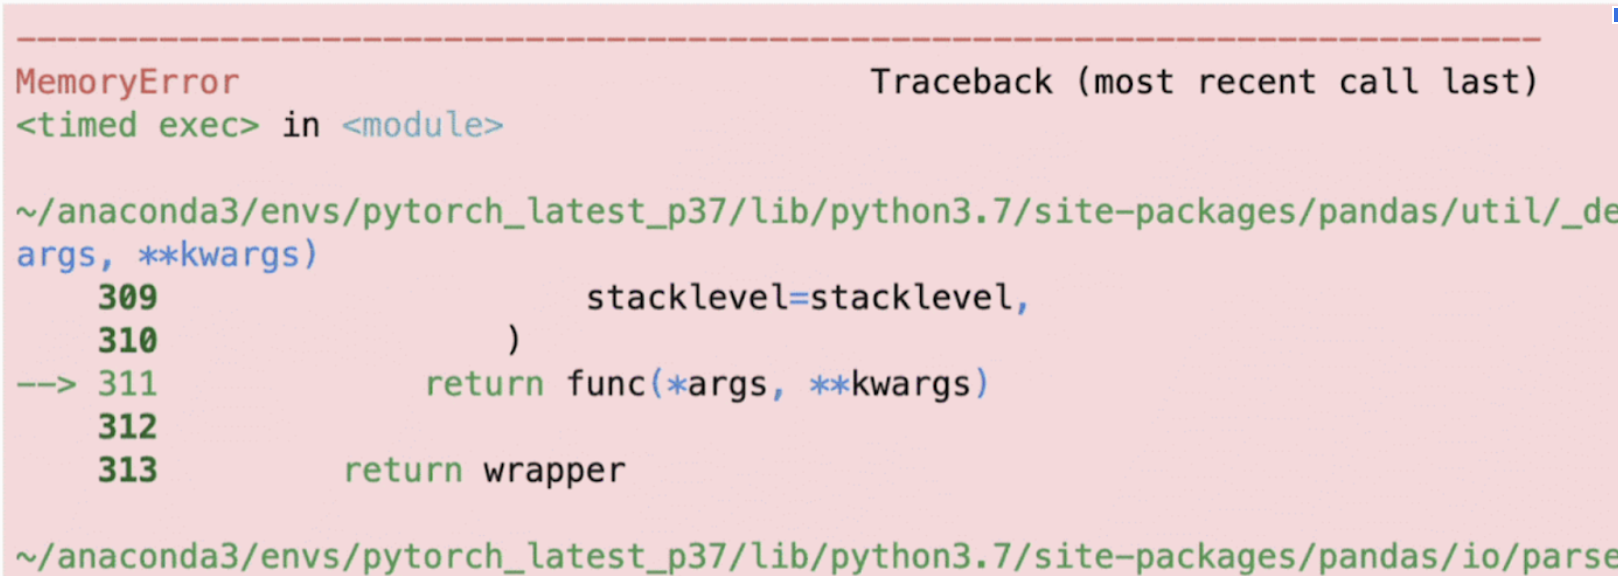

Time to switch over to Dask!

Dask DataFrame allows you to process your tabular data processing pipelines to arbitrarily large datasets. This is because, unlike pandas, it does not need to load the entire dataset into memory to perform computations over the entire dataset. Instead, Dask DataFrame will chop your large dataset into smaller parts ("partitions"), which it can then process in parallel across the multiple cores in your machine or cloud-computing cluster. Read more about these 'under-the-hood' differences between pandas and Dask in the Understanding Dask DataFrame's Architecture chapter.

To switch over to Dask, we'll import `dask.dataframe` as `dd`. From there, we will use familiar pandas syntax to process the data. It will look and feel a lot like pandas...except we're now no longer limited by the memory resources of the machine we're working on.

In [5]:
import dask.dataframe as dd

Let's proceed to read in our dataset. It is saved as a CSV file so we will use the familiar `read_csv` method to read in the data.

Note that Dask supports using an asterisk `*` as a glob string to load in all 12 individual CSV files (1 for each month of the year) into a single Dask DataFrame.

In [ ]:
# load in df
ddf = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2012-*.csv",
)

In [ ]:
# ddf.to_parquet(
#     "s3://coiled-datasets/dask-book/nyc-tlc-2012.parquet",
#     compression="lz4",
# )

Now let's read in the Parquet files.

In [ ]:
ddf = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc-2012.parquet",
    storage_options={"anon": True},
    blocksize="16 MiB",
)

Let’s read in the first 5 rows to double-check that the data has been loaded in correctly:

In [ ]:
ddf.head()

That’s looking good.

Finally, let’s persist the entire DataFrame to our cluster memory. This will speed up computations downstream. Read more about .persist() in Chapter XX.


In [ ]:
ddf = ddf.persist()

## 3. Discover the Data and Assess Quality
You're eager to see what the data looks like and whether you'll be able to discover patterns in the data that will help the NYC Taxi and Limousine Commission motivate its drivers by increasing the probability of high-tip trips.

But before you dive straight into crunching the data, you follow standard data processing best practice and first inspect some basic features of your data to get a sense of what you're working with. How is the data structured? What data types are you working with? Are there any missing values you should be aware of?


### Take a Quick Look at the Data Structure
Let's take a look at our Dask DataFrame `ddf`:

In [ ]:
ddf

This output may be surprising if you're new to Dask and used to pandas.

In pandas, calling a DataFrame outputs some of the content of that DataFrame, typically the first and last 5 rows. It will look something like this:

In [3]:
import pandas as pd

df = pd.read_csv(
    "s3://nyc-tlc/csv_backup/yellow_tripdata_2012-*.csv",
    nrows=1000,
)

df

vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
0         CMT  2012-01-10 23:55:50  2012-01-11 00:03:39                1   
1         CMT  2012-01-11 19:18:25  2012-01-11 19:26:10                1   
2         CMT  2012-01-11 19:19:19  2012-01-11 19:48:15                2   
3         CMT  2012-01-11 19:19:21  2012-01-11 19:27:00                1   
4         CMT  2012-01-11 14:38:15  2012-01-11 14:43:51                1   
..        ...                  ...                  ...              ...   
995       CMT  2012-01-07 14:16:24  2012-01-07 14:26:13                1   
996       CMT  2012-01-07 14:17:41  2012-01-07 14:21:00                1   
997       CMT  2012-01-07 10:47:45  2012-01-07 10:55:32                1   
998       CMT  2012-01-07 08:51:18  2012-01-07 08:54:25                1   
999       CMT  2012-01-07 08:53:05  2012-01-07 08:56:59                1   

     trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0              1.7        -73.994693        40.725031          1   
1              1.1        -73.987955        40.752947          1   
2             18.0        -73.783093        40.648550          2   
3              1.7        -73.967515        40.758454          1   
4              1.2        -74.011315        40.711449          1   
..             ...               ...              ...        ...   
995            2.2        -74.011758        40.709480          1   
996            0.6        -73.984540        40.779495          1   
997            1.7        -73.982146        40.768179          1   
998            0.6        -73.989683        40.762546          1   
999            0.6        -73.995865        40.716546          1   

    store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                    N         -73.975951         40.730781          CRD   
1                    N         -73.994532         40.761040          CSH   
2                    N         -73.996134         40.747624          CRD   
3                    N         -73.956583         40.779903          CRD   
4                    N         -74.002872         40.728131          CSH   
..                 ...                ...               ...          ...   
995                  N         -73.995689         40.736853          CSH   
996                  N         -73.977547         40.785382          CSH   
997                  N         -73.972200         40.788264          CSH   
998                  Y         -73.984837         40.760457          CSH   
999                  N         -73.992219         40.725137          CSH   

     fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0            6.9        0.5      0.5        1.00           0.0          8.90  
1            6.1        1.0      0.5        0.00           0.0          7.60  
2           45.0        0.0      0.5       10.06           4.8         60.36  
3            6.9        1.0      0.5        1.00           0.0          9.40  
4            5.7        0.0      0.5        0.00           0.0          6.20  
..           ...        ...      ...         ...           ...           ...  
995          8.1        0.0      0.5        0.00           0.0          8.60  
996          4.1        0.0      0.5        0.00           0.0          4.60  
997          6.9        0.0      0.5        0.00           0.0          7.40  
998          4.1        0.0      0.5        0.00           0.0          4.60  
999          4.5        0.0      0.5        0.00           0.0          5.00  

[1000 rows x 18 columns]

Calling a Dask DataFrame results in a different kind of output, however. We get a schema containing the column names, number of partitions, and data types...but no rows with data at all! Why is Dask withholding our valuable data from us? 😫 

Remember that Dask DataFrame is designed to work with larger-than-memory tabular datasets. It is able to do so because it does not automatically load the contents of a DataFrame into memory. 

pandas, on the other hand, does always load contents straight into memory. Or in more technical terms, it operates under an eager evaluation model. This is one of the pandas drawbacks that Wes McKinney, the creator of pandas, lists in his ["10 Things I Hate About pandas" talk](https://www.slideshare.net/wesm/practical-medium-data-analytics-with-python).

Dask, on the other hand, uses lazy evaluation. This means Dask does not execute computations unless explicitly instructed to do so. This allows Dask to do a few important things that pandas can't: Dask can process larger-than-memory datasets and Dask can optimize queries. Read more about the benefits of lazy evaluation in the Understanding Dask DataFrame Architecture chapter.

To instruct Dask to actually do something (for example, fetch data from the DataFrame), use the compute() method.

Calling df.compute(), for example, would load the entire DataFrame into memory. Of course we'll want to avoid doing that particular operation because the whole reason why we're using Dask is that our entire DataFrame doesn't fit into memory.

We can, however, call df.head() to inspect the first five rows. Note that head() calls compute() implicitly under the hood, so there's no need to add a compute() at the end of this one.

In [8]:
ddf.head()

vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
0       CMT  2012-01-10 23:55:50  2012-01-11 00:03:39                1   
1       CMT  2012-01-11 19:18:25  2012-01-11 19:26:10                1   
2       CMT  2012-01-11 19:19:19  2012-01-11 19:48:15                2   
3       CMT  2012-01-11 19:19:21  2012-01-11 19:27:00                1   
4       CMT  2012-01-11 14:38:15  2012-01-11 14:43:51                1   

   trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0            1.7        -73.994693        40.725031          1   
1            1.1        -73.987955        40.752947          1   
2           18.0        -73.783093        40.648550          2   
3            1.7        -73.967515        40.758454          1   
4            1.2        -74.011315        40.711449          1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                  N         -73.975951         40.730781          CRD   
1                  N         -73.994532         40.761040          CSH   
2                  N         -73.996134         40.747624          CRD   
3                  N         -73.956583         40.779903          CRD   
4                  N         -74.002872         40.728131          CSH   

   fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0          6.9        0.5      0.5        1.00           0.0          8.90  
1          6.1        1.0      0.5        0.00           0.0          7.60  
2         45.0        0.0      0.5       10.06           4.8         60.36  
3          6.9        1.0      0.5        1.00           0.0          9.40  
4          5.7        0.0      0.5        0.00           0.0          6.20

It looks like each row in the dataset is a single trip, including data points like pick-up/drop-off time and location, the number of passengers in the car, total trip distance, and the fare and tip amounts.

Just like with pandas, you can inspect the column names using the columns attribute:

In [9]:
ddf.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount'],
      dtype='object')

### Inspect and Set the Data Types
You can also inspect the data types of each column using df.dtypes:

In [10]:
ddf.dtypes

vendor_id              object
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
rate_code               int64
store_and_fwd_flag     object
dropoff_longitude     float64
dropoff_latitude      float64
payment_type           object
fare_amount           float64
surcharge             float64
mta_tax               float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
dtype: object

Note that because Dask doesn't load the entire dataset into memory, the data types are inferred by default. Dask DataFrame does this by scanning the first n rows of the dataset. You should be aware that this process is error-prone as a column may contain values of an another data type in rows that aren't scanned during the inferring process.

```
/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/dask/dataframe/io/csv.py:181: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
```

To avoid this kind of error, it's best to set dtypes manually when importing data into a Dask DataFrame. Read more about this in the How to Work with Dask DataFrames chapter.

Knowing this, you decide to re-import your dataset and manually set the dtypes. Having inspected the columns, you realise you can also parse the datetime columns upon import to save time later.

In [ ]:
ddf = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2012-*.csv",
    parse_dates=["pickup_datetime", "dropoff_datetime"],
    dtype={
        "passenger_count": "int8",
        "rate_code": "int8",
        "store_and_fwd_flag": "category",
        "trip_distance": "float32",
        "fare_amount": "float32",
        "surcharge": "float32",
        "mta_tax": "float32",
        "tip_amount": "float32",
        "tolls_amount": "float32",
        "total_amount": "float32",
    },
    storage_options={"anon": True},
    blocksize="16 MiB",
)

Let's inspect the dtypes attribute again to confirm:

In [12]:
ddf.dtypes

vendor_id                     object
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                 int8
trip_distance                float32
pickup_longitude             float64
pickup_latitude              float64
rate_code                       int8
store_and_fwd_flag          category
dropoff_longitude            float64
dropoff_latitude             float64
payment_type                  object
fare_amount                  float32
surcharge                    float32
mta_tax                      float32
tip_amount                   float32
tolls_amount                 float32
total_amount                 float32
dtype: object

You're curious how many records are in your dataset. You can call len(df) to find out. Just like head(), len() calls compute() under the hood to save you the extra typing:

In [17]:
len(ddf)

178544324

### Get Summary Statistics
As a first step in your Exploratory Data Analysis, you want to get a sense of the overall summary statistics of the entire dataset. You can run the familiar describe() method from pandas to achieve this. Remember to add a compute() at the end to trigger the computation:

(TIP) Because this will compute values over the entire dataset, this is quite a heavy computation. To avoid bottlenecks, you could opt to enable adaptive scaling on your Coiled cluster so that more resources will be automatically added when heavy computations are performed. You can do this using cluster.adapt(min_workers=n, max_workers=m) (END TIP)

In [14]:
ddf.describe().compute()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
count     1.785443e+08   1.785443e+08      1.785443e+08     1.785443e+08   
mean      1.688886e+00   2.875534e+00     -7.229951e+01     3.982776e+01   
std       1.351100e+00   3.328334e+00      1.552731e+01     1.195033e+01   
min       0.000000e+00   0.000000e+00     -3.442020e+03    -3.577889e+03   
25%       1.000000e+00   1.320000e+00     -7.398654e+01     4.074325e+01   
50%       1.000000e+00   2.310000e+00     -7.397442e+01     4.075951e+01   
75%       4.000000e+00   4.420000e+00     -7.395842e+01     4.077766e+01   
max       2.540000e+02   1.005000e+02      3.459025e+03     3.577136e+03   

          rate_code  dropoff_longitude  dropoff_latitude   fare_amount  \
count  1.785443e+08       1.785411e+08      1.785411e+08  1.785443e+08   
mean   1.037288e+00      -7.225943e+01      3.980663e+01  1.096040e+01   
std    4.243026e-01       1.542336e+01      1.187377e+01  8.896520e+00   
min    0.000000e+00      -3.509015e+03     -3.547990e+03  2.500000e+00   
25%    1.000000e+00      -7.398597e+01      4.074421e+01  7.300000e+00   
50%    1.000000e+00      -7.397327e+01      4.076064e+01  1.090000e+01   
75%    1.000000e+00      -7.395449e+01      4.077805e+01  2.000000e+01   
max    2.210000e+02       3.460427e+03      3.577135e+03  5.000000e+02   

          surcharge       mta_tax    tip_amount  tolls_amount  total_amount  
count  1.785443e+08  1.785443e+08  1.785443e+08  1.785443e+08  1.785443e+08  
mean   3.194212e-01  4.983736e-01  1.120814e+00  2.125202e-01  1.311153e+01  
std    3.615596e-01  2.847020e-02  1.922789e+00  1.051989e+00  1.059587e+01  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.500000e+00  
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00  9.000000e+00  
50%    5.000000e-01  5.000000e-01  1.160000e+00  0.000000e+00  1.296000e+01  
75%    1.000000e+00  5.000000e-01  3.100000e+00  0.000000e+00  2.270000e+01  
max    1.550000e+01  5.000000e-01  2.000000e+02  2.000000e+01  6.400000e+02

That's a lot of information. You decide to focus on the essentials for now: the trends in the tip_amount, your feature of interest:

In [13]:
ddf.tip_amount.describe().compute()

count    1.785443e+08
mean     1.120814e+00
std      1.922789e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.160000e+00
75%      3.100000e+00
max      2.000000e+02
Name: tip_amount, dtype: float64

### Perform Groupby Aggregations
To begin to understand how the features in your dataset relate to one another, you'd like to perform some groupby aggregations next. 

(NOTE) Because these are aggregations, the result will comfortably fit into memory and we can call compute() without having to worry about running into a MemoryError. (END NOTE)

To start, you're curious about the mean tip_amount by payment_type:

In [18]:
ddf.groupby("payment_type").tip_amount.mean().compute()

payment_type
CRD    2.319004
CSH    0.001043
DIS    0.019128
NOC    0.012164
UNK    3.176750
Name: tip_amount, dtype: float64

Note that except for the compute() call at the end, the syntax is identical to pandas.

Let's add a little more depth to this calculation by also calculating the standard deviation, count, and maximum tip amounts per payment type:

In [19]:
ddf.groupby("payment_type").agg(
    {"tip_amount": ["mean", "std", "max", "count"]}
).compute()

CPU times: user 359 ms, sys: 14.8 ms, total: 374 ms
Wall time: 19.9 s


tip_amount                                
                   mean       std         max     count
payment_type                                           
CRD            2.319005  2.204733  200.000000  86157354
CSH            0.001043  0.091910  123.650002  91904363
DIS            0.019128  0.710399  144.500000     98649
NOC            0.012164  0.577096  147.520004    316574
UNK            3.176750  3.095601   95.000000     67384

There's some signal here that suggests that trips that were paid for by card tend to have higher tips on average.

Next, you're interested in how the tip amount varies per the passenger count:

In [21]:
res = (
    ddf.groupby("passenger_count")
    .agg({"tip_amount": ["mean", "std", "max", "count"]})
    .compute()
)
res

tip_amount                             
                      mean       std     max      count
passenger_count                                        
-48               0.000000  0.000000    0.00        107
 0                0.862099  1.517688  165.00    1274858
 1                1.151011  1.940186  200.00  123955714
 2                1.081580  1.924790  200.00   24900623
 3                0.962949  1.785215  200.00    7716364
 4                0.844519  1.775980  200.00    3752549
 5                1.102733  1.886802  200.00   12063339
 6                1.128365  1.931465  200.00    4880708
 7                0.544118  0.973056    3.00         17
 8                0.350769  0.913514    3.06         13
 9                0.806800  1.098820    3.00         25
 65               0.000000       NaN    0.00          1
 66               1.500000       NaN    1.50          1
-79               1.000000       NaN    1.00          1
 10               0.000000       NaN    0.00          1
-9                2.300000       NaN    2.30          1
-7                0.000000       NaN    0.00          1
-2                0.000000       NaN    0.00          1

Before you even look at the patterns here, something else jumps out at you loud and clear here: there are some highly improbably (as well as straight-up impossible) values in the passenger_count column. This will require some data cleaning later.

You decide to plot just the mean aggregate of the meaningful passenger_count valies on a bar graph to better visualise what's going on:

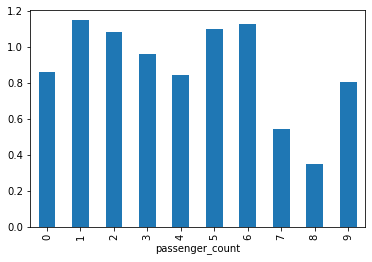

In [35]:
res["tip_amount"]["mean"].loc[0:9].plot(kind="bar");

It looks like most passenger_count values fluctuate between the 0.8 and 1.2 range, with a significant drop for trips with 7 or 8 passengers.

The high volume of trips with 0 passengers is also noteworthy. This can be partially explained by the fact that this feature is a driver-reported feature, so it's likely that trips with a 0 value are ones where the driver did not report a value.

Finally, you'd also like to know something about the relationship between trip_distance and tip_amount. You assume this is likely a relatively linear relationship (longer trips mean higher tips) but want to check your assumption:

In [36]:
ddf.plot(x="trip_distance", y="tip_amount", kind="scatter")

AttributeError: 'DataFrame' object has no attribute 'plot'

Dask does not support the straightforward plot() functionality you may be used to when coming from pandas. This is because Dask DataFrames typically contain million- or billion-point datasets. Visualizing all of these points on a single matplotlib graph does not produce meaningful graphics due to extreme overlay of datapoints. We'll illustrate this in detail and walk you through alternatives for plotting Dask DataFrames in Section 5 of this chapter.

### Find Missing Values
Having lots of data is great. But quantity is meaningless if it is not matched with quality. You want to make sure that the data you're going to be using to perform your analyses is clean and dependable. We've already potential data quality issues with the incorrect values for the passenger_count column.

First, you decide to inspect the number of missing values per column:

In [37]:
ddf.isna().sum().compute()

vendor_id                    0
pickup_datetime              0
dropoff_datetime             0
passenger_count              0
trip_distance                0
pickup_longitude             0
pickup_latitude              0
rate_code                    0
store_and_fwd_flag    88024576
dropoff_longitude         3186
dropoff_latitude          3186
payment_type                 0
fare_amount                  0
surcharge                    0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
total_amount                 0
dtype: int64

It looks like the store_and_fwd_flag column is missing a significant portion of its values. This is not a huge problem as this column contains technical information about how data was sent from the taxi cab to the server. This is information that is not crucial to the analysis you're running.

The dropoff longitude and latitude values, on the other hand, may prove of value. Luckily the portion of missing values is negligible compared to the 178+ million records we have available for this year.

## 4. Clean the Data
Working with 25GB of data is pretty cool. But now that your manager has seen what Dask is capable of, she asks you to look at patterns over a much larger timespan. She'd like you to analyse the difference in tip amounts between the 5-year periods *before* and *after* rideshare technology was introduced in New York: 2009-2013 and 2014-2018, respectively. This means crunching ~250GB of data. 

This will require some data cleaning. You've been notified that the schema for the data changes throughout that period: new schemas were introduced in 2010, 2015 and 2017. This means that columns names and data types will need to be standardised. 

The schema change in 2017 is especially significant because, as you'll see, from that year onwards the NYC TLC decided to shield exact pickup and dropoff locations for privacy reasons. This means we'll need to perform a spatial join to recover some of the geographical data for the years 2017 and 2018.

Let's get crunching.

### Standardize Schema

#### 2009 Data

In [39]:
# read in raw 2009 data
ddf_2009 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2009-*.csv",
)

In [ ]:
# verify that we can read it
ddf_2009.head()

This throws an error because of mismatched data types. Dask inferred the data type int64 for the column Tolls_Amt by reading the first few lines, but then later encountered values of dtype float64.

Let's set the dtype for Tolls_Amt to float64. We'll save you a step here by telling you we should also set the store_and_forward column to object dtype to avoid a similar mismatched dtype error:

In [41]:
# read in raw 2009 data
ddf_2009 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2009-*.csv",
    dtype={
        "Tolls_Amt": "float64",
        "store_and_forward": "object",
    },
)

In [42]:
ddf_2009.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
0         VTS  2009-01-04 02:52:00   2009-01-04 03:02:00                1   
1         VTS  2009-01-04 03:31:00   2009-01-04 03:38:00                3   
2         VTS  2009-01-03 15:43:00   2009-01-03 15:57:00                5   
3         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
4         DDS  2009-01-24 16:18:23   2009-01-24 16:24:56                1   

   Trip_Distance  Start_Lon  Start_Lat  Rate_Code store_and_forward  \
0           2.63 -73.991957  40.721567        NaN               NaN   
1           4.55 -73.982102  40.736290        NaN               NaN   
2          10.35 -74.002587  40.739748        NaN               NaN   
3           5.00 -73.974267  40.790955        NaN               NaN   
4           0.40 -74.001580  40.719382        NaN               NaN   

     End_Lon    End_Lat Payment_Type  Fare_Amt  surcharge  mta_tax  Tip_Amt  \
0 -73.993803  40.695922         CASH       8.9        0.5      NaN     0.00   
1 -73.955850  40.768030       Credit      12.1        0.5      NaN     2.00   
2 -73.869983  40.770225       Credit      23.7        0.0      NaN     4.74   
3 -73.996558  40.731849       CREDIT      14.9        0.5      NaN     3.05   
4 -74.008378  40.720350         CASH       3.7        0.0      NaN     0.00   

   Tolls_Amt  Total_Amt  
0        0.0       9.40  
1        0.0      14.60  
2        0.0      28.44  
3        0.0      18.45  
4        0.0       3.70

Excellent, that's looking better. You'll notice quickly, though, that these columns names don't all correspond to the column names we saw for the year 2012. Perhaps the data engineering team had some staff changes between 2009 and 2010 and the new team decided to update the column names. We'll need to standardise this schema in order to join all the data for the 5-year period into a single dataframe.

Before we do that, you also spot an opportunity for increased efficiency here: you can parse the datetime information in Trip_Pickup_DateTime and Trip_Dropoff_DateTime upon import. So let's:

1. Re-import with parse_dates, and then
2. Change the column names to standardize the schema

In [43]:
# read in raw 2009 data
ddf_2009 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2009-*.csv",
    parse_dates=["Trip_Pickup_DateTime", "Trip_Dropoff_DateTime"],
    dtype={
        "Tolls_Amt": "float64",
        "store_and_forward": "object",
    },
)

In [44]:
# rename columns to standardize schema
ddf_2009 = ddf_2009.rename(
    columns={
        "vendor_name": "vendor_id",
        "Trip_Pickup_DateTime": "pickup_datetime",
        "Trip_Dropoff_DateTime": "dropoff_datetime",
        "Passenger_Count": "passenger_count",
        "Trip_Distance": "trip_distance",
        "Start_Lon": "pickup_longitude",
        "Start_Lat": "pickup_latitude",
        "Rate_Code": "rate_code",
        "store_and_forward": "store_and_fwd_flag",
        "End_Lon": "dropoff_longitude",
        "End_Lat": "dropoff_latitude",
        "Payment_Type": "payment_type",
        "Fare_Amt": "fare_amount",
        "surcharge": "surcharge",
        "mta_tax": "mta_tax",
        "Tip_Amt": "tip_amount",
        "Tolls_Amt": "tolls_amount",
        "Total_Amt": "total_amount",
    }
)

In [45]:
ddf_2009.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   
3       DDS 2009-01-01 20:52:58 2009-01-01 21:14:00                1   
4       DDS 2009-01-24 16:18:23 2009-01-24 16:24:56                1   

   trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0           2.63        -73.991957        40.721567        NaN   
1           4.55        -73.982102        40.736290        NaN   
2          10.35        -74.002587        40.739748        NaN   
3           5.00        -73.974267        40.790955        NaN   
4           0.40        -74.001580        40.719382        NaN   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                NaN         -73.993803         40.695922         CASH   
1                NaN         -73.955850         40.768030       Credit   
2                NaN         -73.869983         40.770225       Credit   
3                NaN         -73.996558         40.731849       CREDIT   
4                NaN         -74.008378         40.720350         CASH   

   fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0          8.9        0.5      NaN        0.00           0.0          9.40  
1         12.1        0.5      NaN        2.00           0.0         14.60  
2         23.7        0.0      NaN        4.74           0.0         28.44  
3         14.9        0.5      NaN        3.05           0.0         18.45  
4          3.7        0.0      NaN        0.00           0.0          3.70

Let's make absolutely sure that the column names are the same as the data we have for 2012:

In [50]:
ddf.columns == ddf_2009.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

This looks great. You decide to store the dataset in this new format to an S3 bucket in the Parquet file format. Parquet has a number of benefits over CSV, including more efficient (parallel) computations and the ability to hard-code dtypes. 

The code below writes the dataset to the coiled-datasets S3 bucket. To write the dataset to a bucket of your own, you will need to change the path following the format *s3://your-bucket-name/your-directory/*. 

Before writing the file to Parquet, you decided to first repartition the Dask DataFrame into equal partitions of 100MiB each. Method chaining makes this easy: 

In [ ]:
ddf_2009.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

To make absolutely sure of your work, you decide to import the Parquet file and compute a test computation over all the columns. The describe() function is a great candidate for this as it computes summary statistics over all the data but its output is small enough to fit comfortably into memory. This way we'll ensure that there are no dtype issues or anything like that:

In [9]:
ddf_2009 = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009",
    engine="pyarrow",
)

In [9]:
# perform computation over all columns
ddf.describe().compute()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
count     1.785443e+08   1.785443e+08      1.785443e+08     1.785443e+08   
mean      1.688727e+00            inf     -7.229951e+01     3.982776e+01   
std       1.341742e+00   3.328339e+00      1.552731e+01     1.195033e+01   
min      -7.900000e+01   0.000000e+00     -3.442020e+03    -3.577889e+03   
25%       1.000000e+00   1.320312e+00     -7.398654e+01     4.074325e+01   
50%       1.000000e+00   2.310547e+00     -7.397442e+01     4.075951e+01   
75%       4.000000e+00   4.421875e+00     -7.395842e+01     4.077766e+01   
max       6.600000e+01   1.005000e+02      3.459025e+03     3.577136e+03   

          rate_code  dropoff_longitude  dropoff_latitude   fare_amount  \
count  1.785443e+08       1.785411e+08      1.785411e+08  1.785443e+08   
mean   1.036727e+00      -7.225943e+01      3.980663e+01           inf   
std    3.003039e-01       1.542336e+01      1.187377e+01  8.896515e+00   
min   -1.280000e+02      -3.509015e+03     -3.547990e+03  2.500000e+00   
25%    1.000000e+00      -7.398597e+01      4.074421e+01  7.300781e+00   
50%    1.000000e+00      -7.397327e+01      4.076064e+01  1.089844e+01   
75%    1.000000e+00      -7.395449e+01      4.077805e+01  2.000000e+01   
max    7.900000e+01       3.460427e+03      3.577135e+03  5.000000e+02   

          surcharge       mta_tax    tip_amount  tolls_amount  total_amount  
count  1.785443e+08  1.785443e+08  1.785443e+08  1.785443e+08  1.785443e+08  
mean            inf  4.984934e-01           inf  2.125494e-01           inf  
std    3.615596e-01  2.847020e-02  1.922799e+00  1.052118e+00  1.059644e+01  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.500000e+00  
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00  9.000000e+00  
50%    5.000000e-01  5.000000e-01  1.160156e+00  0.000000e+00  1.296094e+01  
75%    1.000000e+00  5.000000e-01  3.099609e+00  0.000000e+00  2.270312e+01  
max    1.550000e+01  5.000000e-01  2.000000e+02  2.000000e+01  6.400000e+02

That computation completed without any errors. This gives you enough confidence to proceed.

#### 2010 Data

Let's load in the raw 2010 CSV data:

In [35]:
# read in raw 2010 data
ddf_2010 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2010-*.csv",
    parse_dates=["pickup_datetime", "dropoff_datetime"],
    on_bad_lines="skip",
    dtype={
        "tolls_amount": "float64",
        "store_and_fwd_flag": "object",
    },
)

Inspect the first 5 rows:

In [11]:
ddf_2010.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2010-01-26 07:41:00 2010-01-26 07:45:00                1   
1       DDS 2010-01-30 23:31:00 2010-01-30 23:46:12                1   
2       DDS 2010-01-18 20:22:20 2010-01-18 20:38:12                1   
3       VTS 2010-01-09 01:18:00 2010-01-09 01:35:00                2   
4       CMT 2010-01-18 19:10:14 2010-01-18 19:17:07                1   

   trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0           0.75        -73.956778        40.767750          1   
1           5.90        -73.996118        40.763932          1   
2           4.00        -73.979673        40.783790          1   
3           4.70        -73.977922        40.763997          1   
4           0.60        -73.990924        40.734682          1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                NaN         -73.965957         40.765232          CAS   
1                NaN         -73.981512         40.741193          CAS   
2                NaN         -73.917852         40.878560          CAS   
3                NaN         -73.923908         40.759725          CAS   
4                  0         -73.995511         40.739088          Cre   

   fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0          4.5        0.0      0.5        0.00           0.0          5.00  
1         15.3        0.5      0.5        0.00           0.0         16.30  
2         11.7        0.5      0.5        0.00           0.0         12.70  
3         13.3        0.5      0.5        0.00           0.0         14.30  
4          5.3        0.0      0.5        0.87           0.0          6.67

Verify that the column names are identical:

In [12]:
# verify columns names are identical
ddf_2009.columns == ddf_2010.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

And check the dtypes:

In [33]:
# verify dtypes are identical
ddf_2009.dtypes == ddf_2010.dtypes

vendor_id              True
pickup_datetime        True
dropoff_datetime       True
passenger_count        True
trip_distance          True
pickup_longitude       True
pickup_latitude        True
rate_code             False
store_and_fwd_flag     True
dropoff_longitude      True
dropoff_latitude       True
payment_type           True
fare_amount            True
surcharge              True
mta_tax                True
tip_amount             True
tolls_amount           True
total_amount           True
dtype: bool

All column dtypes are matching except for the rate_code column. Let's take a closer look.

In [39]:
ddf_2009.rate_code.dtype, ddf_2010.rate_code.dtype

(dtype('float64'), dtype('int64'))

In the 2009 dataset rate_code is types as a float64; in the 2010 dataset it's typed as int64. Both of these contain numeric data, but one of the main differences between float and int dtypes is that float can contain NaNs. This makes you wonder whether the presence of NaNs in the 2009 rate_code column might be the reason for this dtype discrepancy:

In [36]:
ddf_2009.rate_code.isna().sum().compute()

170896055

That seems a likely explanation. 

Since this column contains almost 90% NaNs and it is not a variable you're interested in considering in your final analysis, you decide to keep the discrepancy for now as you will be dropping the rate_code column later.

Let's repartition and write to Parquet:

In [17]:
ddf_2010.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2010",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

[None]

Verify that this works:

In [40]:
ddf_2010 = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2010",
    engine="pyarrow",
)

In [41]:
ddf_2010.describe().compute()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
count     1.689944e+08   1.689944e+08      1.689944e+08     1.689944e+08   
mean      1.674221e+00   5.864681e+00     -7.239051e+01     3.988347e+01   
std       1.300666e+00   5.409394e+03      1.102328e+01     7.053625e+00   
min       0.000000e+00  -2.147483e+07     -3.509015e+03    -3.579139e+03   
25%       1.000000e+00   1.100000e+00     -7.399120e+01     4.073721e+01   
50%       1.000000e+00   1.810000e+00     -7.398075e+01     4.075436e+01   
75%       3.000000e+00   3.300000e+00     -7.396519e+01     4.076858e+01   
max       2.550000e+02   1.620163e+07      3.569931e+03     3.377993e+03   

          rate_code  dropoff_longitude  dropoff_latitude   fare_amount  \
count  1.689944e+08       1.689942e+08      1.689942e+08  1.689944e+08   
mean   1.032463e+00      -7.241661e+01      3.989821e+01  9.844589e+00   
std    4.236116e-01       1.089876e+01      7.027043e+00  1.664848e+03   
min    0.000000e+00      -3.579139e+03     -3.538432e+03 -2.147481e+07   
25%    1.000000e+00      -7.399054e+01      4.073634e+01  5.700000e+00   
50%    1.000000e+00      -7.397901e+01      4.075478e+01  8.100000e+00   
75%    1.000000e+00      -7.396185e+01      4.076926e+01  1.210000e+01   
max    2.210000e+02       3.443651e+03      3.510381e+03  9.396007e+04   

          surcharge       mta_tax    tip_amount  tolls_amount  total_amount  
count  1.689944e+08  1.689944e+08  1.689944e+08  1.689944e+08  1.689944e+08  
mean   3.221727e-01  4.955940e-01  7.605548e-01 -7.496016e-02  1.135107e+01  
std    3.693486e-01  1.345498e-01  1.735413e+02  2.336194e+03  2.873962e+03  
min   -1.000000e+00 -1.000000e+00 -1.677720e+06 -2.147484e+07 -2.147483e+07  
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00  7.200000e+00  
50%    5.000000e-01  5.000000e-01  5.000000e-01  0.000000e+00  9.800000e+00  
75%    5.000000e-01  5.000000e-01  2.000000e+00  0.000000e+00  1.400000e+01  
max    6.157800e+02  1.311220e+03  9.380200e+02  5.510070e+03  9.396057e+04

Looking good.

We'll take a little shortcut here and tell you that the method we applied to the 2010 data will work for the following years as well. You can run the cells below for the years 2011, 2012 and 2013 by changing the year:

#### 2011 Data

Let's proceed to load in the 2011 CSV data:

In [13]:
ddf_2011 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2011-*.csv",
    parse_dates=["pickup_datetime", "dropoff_datetime"],
    dtype={
        "tip_amount": "float64",
        "tolls_amount": "float64",
    },
)

In [14]:
ddf_2011.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       CMT 2011-01-29 02:38:35 2011-01-29 02:47:07                1   
1       CMT 2011-01-28 10:38:19 2011-01-28 10:42:18                1   
2       CMT 2011-01-28 23:49:58 2011-01-28 23:57:44                3   
3       CMT 2011-01-28 23:52:09 2011-01-28 23:59:21                3   
4       CMT 2011-01-28 10:34:39 2011-01-28 11:25:50                1   

   trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0            1.2        -74.005254        40.729084          1   
1            0.4        -73.968585        40.759171          1   
2            1.2        -73.980710        40.742390          1   
3            0.8        -73.993773        40.747329          1   
4            5.3        -73.991475        40.749936          1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                  N         -73.988697         40.727127          CSH   
1                  N         -73.964336         40.764665          CSH   
2                  N         -73.987028         40.729532          CSH   
3                  N         -73.991378         40.750050          CSH   
4                  N         -73.950237         40.775626          CSH   

   fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0          6.1        0.5      0.5         0.0           0.0           7.1  
1          4.1        0.0      0.5         0.0           0.0           4.6  
2          6.1        0.5      0.5         0.0           0.0           7.1  
3          5.3        0.5      0.5         0.0           0.0           6.3  
4         25.3        0.0      0.5         0.0           0.0          25.8

Verify the column names are identical:

In [15]:
ddf_2011.columns == ddf_2010.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Verify the dtypes:

In [18]:
ddf_2010.dtypes == ddf_2011.dtypes

vendor_id             True
pickup_datetime       True
dropoff_datetime      True
passenger_count       True
trip_distance         True
pickup_longitude      True
pickup_latitude       True
rate_code             True
store_and_fwd_flag    True
dropoff_longitude     True
dropoff_latitude      True
payment_type          True
fare_amount           True
surcharge             True
mta_tax               True
tip_amount            True
tolls_amount          True
total_amount          True
dtype: bool

Excellent, let's repartition and write to Parquet:

In [19]:
ddf_2011.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2011",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

[None]

Verify by reading in Parquet file and calling describe():

In [53]:
ddf_2011 = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2011",
    engine="pyarrow",
)

In [23]:
ddf_2011.describe().compute()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
count     1.768972e+08   1.768972e+08      1.768972e+08     1.768972e+08   
mean      1.651734e+00   2.798126e+00     -7.229130e+01     3.982905e+01   
std       1.274207e+00   3.266207e+00      1.896707e+01     1.618590e+01   
min       0.000000e+00   0.000000e+00     -3.442060e+03    -3.579139e+03   
25%       1.000000e+00   1.100000e+00     -7.399135e+01     4.073677e+01   
50%       1.000000e+00   1.880000e+00     -7.398090e+01     4.075451e+01   
75%       3.000000e+00   3.400000e+00     -7.396425e+01     4.076846e+01   
max       2.550000e+02   1.000000e+02      3.569918e+03     3.550366e+03   

          rate_code  dropoff_longitude  dropoff_latitude   fare_amount  \
count  1.768972e+08       1.768964e+08      1.768964e+08  1.768972e+08   
mean   1.034983e+00      -7.233329e+01      3.984933e+01  1.024531e+01   
std    3.633345e-01       1.882392e+01      1.616479e+01  8.117036e+00   
min    0.000000e+00      -3.508936e+03     -3.550958e+03  2.500000e+00   
25%    1.000000e+00      -7.399080e+01      4.073601e+01  6.100000e+00   
50%    1.000000e+00      -7.397924e+01      4.075482e+01  8.500000e+00   
75%    1.000000e+00      -7.396156e+01      4.076923e+01  1.250000e+01   
max    2.520000e+02       3.460427e+03      3.577133e+03  5.000000e+02   

          surcharge       mta_tax    tip_amount  tolls_amount  total_amount  
count  1.768972e+08  1.768972e+08  1.768972e+08  1.768972e+08  1.768972e+08  
mean   3.208127e-01  4.985174e-01  9.596616e-01  2.010630e-01  1.222537e+01  
std    3.630713e-01  2.718639e-02  1.751924e+00  1.011169e+00  9.627921e+00  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.500000e+00  
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00  7.400000e+00  
50%    5.000000e-01  5.000000e-01  1.000000e+00  0.000000e+00  1.000000e+01  
75%    5.000000e-01  5.000000e-01  2.000000e+00  0.000000e+00  1.470000e+01  
max    1.580000e+01  5.000000e-01  2.000000e+02  2.000000e+01  6.000000e+02

#### 2012 Data
Let's do the same for the 2012 data:

In [ ]:
ddf_2012 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2012-*.csv",
    parse_dates=["pickup_datetime", "dropoff_datetime"],
    dtype={
        "tip_amount": "float64",
        "tolls_amount": "float64",
    },
)

In [25]:
ddf_2012.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       CMT 2012-01-10 23:55:50 2012-01-11 00:03:39                1   
1       CMT 2012-01-11 19:18:25 2012-01-11 19:26:10                1   
2       CMT 2012-01-11 19:19:19 2012-01-11 19:48:15                2   
3       CMT 2012-01-11 19:19:21 2012-01-11 19:27:00                1   
4       CMT 2012-01-11 14:38:15 2012-01-11 14:43:51                1   

   trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0            1.7        -73.994693        40.725031          1   
1            1.1        -73.987955        40.752947          1   
2           18.0        -73.783093        40.648550          2   
3            1.7        -73.967515        40.758454          1   
4            1.2        -74.011315        40.711449          1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                  N         -73.975951         40.730781          CRD   
1                  N         -73.994532         40.761040          CSH   
2                  N         -73.996134         40.747624          CRD   
3                  N         -73.956583         40.779903          CRD   
4                  N         -74.002872         40.728131          CSH   

   fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0          6.9        0.5      0.5        1.00           0.0          8.90  
1          6.1        1.0      0.5        0.00           0.0          7.60  
2         45.0        0.0      0.5       10.06           4.8         60.36  
3          6.9        1.0      0.5        1.00           0.0          9.40  
4          5.7        0.0      0.5        0.00           0.0          6.20

In [26]:
ddf_2012.columns == ddf_2011.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [27]:
ddf_2012.dtypes == ddf_2011.dtypes

vendor_id             True
pickup_datetime       True
dropoff_datetime      True
passenger_count       True
trip_distance         True
pickup_longitude      True
pickup_latitude       True
rate_code             True
store_and_fwd_flag    True
dropoff_longitude     True
dropoff_latitude      True
payment_type          True
fare_amount           True
surcharge             True
mta_tax               True
tip_amount            True
tolls_amount          True
total_amount          True
dtype: bool

That looks good. Let's repartition and write to Parquet:

In [29]:
ddf_2012.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2012",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

[None]

Verify:

In [54]:
ddf_2012 = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2012",
    engine="pyarrow",
)

In [31]:
ddf_2012.describe().compute()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
count     1.785443e+08   1.785443e+08      1.785443e+08     1.785443e+08   
mean      1.688886e+00   2.875534e+00     -7.229951e+01     3.982776e+01   
std       1.351100e+00   3.328334e+00      1.552731e+01     1.195033e+01   
min       0.000000e+00   0.000000e+00     -3.442020e+03    -3.577889e+03   
25%       1.000000e+00   1.300000e+00     -7.398629e+01     4.074348e+01   
50%       1.000000e+00   2.200000e+00     -7.397435e+01     4.076020e+01   
75%       4.000000e+00   4.060000e+00     -7.395897e+01     4.077649e+01   
max       2.540000e+02   1.005000e+02      3.459025e+03     3.577136e+03   

          rate_code  dropoff_longitude  dropoff_latitude   fare_amount  \
count  1.785443e+08       1.785411e+08      1.785411e+08  1.785443e+08   
mean   1.037288e+00      -7.225943e+01      3.980663e+01  1.096040e+01   
std    4.243026e-01       1.542336e+01      1.187377e+01  8.896520e+00   
min    0.000000e+00      -3.509015e+03     -3.547990e+03  2.500000e+00   
25%    1.000000e+00      -7.398624e+01      4.074419e+01  7.300000e+00   
50%    1.000000e+00      -7.397395e+01      4.075992e+01  1.090000e+01   
75%    1.000000e+00      -7.395538e+01      4.077806e+01  1.800000e+01   
max    2.210000e+02       3.460427e+03      3.577135e+03  5.000000e+02   

          surcharge       mta_tax    tip_amount  tolls_amount  total_amount  
count  1.785443e+08  1.785443e+08  1.785443e+08  1.785443e+08  1.785443e+08  
mean   3.194212e-01  4.983736e-01  1.120814e+00  2.125202e-01  1.311153e+01  
std    3.615596e-01  2.847020e-02  1.922789e+00  1.051989e+00  1.059587e+01  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.500000e+00  
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00  9.100000e+00  
50%    5.000000e-01  5.000000e-01  1.200000e+00  0.000000e+00  1.300000e+01  
75%    1.000000e+00  5.000000e-01  3.000000e+00  0.000000e+00  2.100000e+01  
max    1.550000e+01  5.000000e-01  2.000000e+02  2.000000e+01  6.400000e+02

#### 2013 Data
Finally, let's do the same for the 2013 data:

In [32]:
ddf_2013 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2013-*.csv",
    parse_dates=["pickup_datetime", "dropoff_datetime"],
    dtype={
        "tip_amount": "float64",
        "tolls_amount": "float64",
    },
)

In [33]:
ddf_2013.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       CMT 2013-01-01 15:11:48 2013-01-01 15:18:10                4   
1       CMT 2013-01-06 00:18:35 2013-01-06 00:22:54                1   
2       CMT 2013-01-05 18:49:41 2013-01-05 18:54:23                1   
3       CMT 2013-01-07 23:54:15 2013-01-07 23:58:20                2   
4       CMT 2013-01-07 23:25:03 2013-01-07 23:34:24                1   

   trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0            1.0        -73.978165        40.757977          1   
1            1.5        -74.006680        40.731781          1   
2            1.1        -74.004711        40.737770          1   
3            0.7        -73.974600        40.759945          1   
4            2.1        -73.976252        40.748528          1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                  N         -73.989840         40.751173          CSH   
1                  N         -73.994499         40.750659          CSH   
2                  N         -74.009831         40.726000          CSH   
3                  N         -73.984737         40.759388          CSH   
4                  N         -74.002583         40.747867          CSH   

   fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0          6.5        0.0      0.5         0.0           0.0           7.0  
1          6.0        0.5      0.5         0.0           0.0           7.0  
2          5.5        1.0      0.5         0.0           0.0           7.0  
3          5.0        0.5      0.5         0.0           0.0           6.0  
4          9.5        0.5      0.5         0.0           0.0          10.5

In [34]:
ddf_2013.columns == ddf_2012.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [35]:
ddf_2013.dtypes == ddf_2012.dtypes

vendor_id             True
pickup_datetime       True
dropoff_datetime      True
passenger_count       True
trip_distance         True
pickup_longitude      True
pickup_latitude       True
rate_code             True
store_and_fwd_flag    True
dropoff_longitude     True
dropoff_latitude      True
payment_type          True
fare_amount           True
surcharge             True
mta_tax               True
tip_amount            True
tolls_amount          True
total_amount          True
dtype: bool

Repartition and write to Parquet:

In [36]:
ddf_2013.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2013",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

[None]

Verify:

In [55]:
ddf_2013 = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2013",
    engine="pyarrow",
)

In [38]:
ddf_2013.describe().compute()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
count     1.731798e+08   1.731798e+08      1.731798e+08     1.731798e+08   
mean      1.709419e+00   8.305137e+00     -7.245156e+01     3.975293e+01   
std       1.376744e+00   6.639903e+03      1.129179e+01     8.780317e+00   
min       0.000000e+00   0.000000e+00     -3.084296e+03    -3.547921e+03   
25%       1.000000e+00   1.300000e+00     -7.398486e+01     4.074013e+01   
50%       1.000000e+00   2.100000e+00     -7.397131e+01     4.075653e+01   
75%       4.000000e+00   4.000000e+00      0.000000e+00     4.077099e+01   
max       2.550000e+02   1.533180e+07      2.945959e+03     3.310364e+03   

          rate_code  dropoff_longitude  dropoff_latitude   fare_amount  \
count  1.731798e+08       1.731763e+08      1.731763e+08  1.731798e+08   
mean   1.033721e+00      -7.240810e+01      3.972998e+01  1.235018e+01   
std    3.391333e-01       1.141710e+01      8.867563e+00  1.761782e+01   
min    0.000000e+00      -3.116270e+03     -3.547921e+03 -1.430000e+03   
25%    1.000000e+00      -7.398353e+01      4.074021e+01  7.500000e+00   
50%    1.000000e+00      -7.396818e+01      4.075668e+01  1.050000e+01   
75%    1.000000e+00       0.000000e+00      4.077115e+01  1.650000e+01   
max    2.390000e+02       2.386995e+03      3.577132e+03  1.589958e+05   

          surcharge       mta_tax    tip_amount  tolls_amount  total_amount  
count  1.731798e+08  1.731798e+08  1.731798e+08  1.731798e+08  1.731798e+08  
mean   3.193474e-01  4.982070e-01  1.365102e+00  2.500290e-01  1.479010e+01  
std    4.093622e-01  3.477812e-02  2.193724e+00  1.213595e+00  6.902725e+01  
min   -1.950000e+01 -5.000000e-01 -9.682000e+01 -2.225000e+01 -1.430000e+03  
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00  9.500000e+00  
50%    5.000000e-01  5.000000e-01  1.500000e+00  0.000000e+00  1.300000e+01  
75%    1.000000e+00  5.000000e-01  3.250000e+00  0.000000e+00  2.100000e+01  
max    8.545000e+02  8.005000e+01  8.881900e+02  9.600900e+02  6.859081e+05

### Concatenate DataFrames
Excellent, you've now standardized the schema and dtypes for all the 5 years of data you're interested in. You now want to join all this data into a single Dask DataFrame using the concat() method:

In [56]:
ddf = dd.concat([ddf_2009, ddf_2010, ddf_2011, ddf_2012, ddf_2013])

Let's triple-check our work here and inspect the data types:

In [57]:
ddf.dtypes == ddf_2013.dtypes

vendor_id              True
pickup_datetime        True
dropoff_datetime       True
passenger_count        True
trip_distance          True
pickup_longitude       True
pickup_latitude        True
rate_code             False
store_and_fwd_flag     True
dropoff_longitude      True
dropoff_latitude       True
payment_type           True
fare_amount            True
surcharge              True
mta_tax                True
tip_amount             True
tolls_amount           True
total_amount           True
dtype: bool

As you'd expected, all dtypes except rate_code match. 

Let's make sure we can compute over all the data by calling describe():

In [58]:
ddf.describe().compute()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
count     8.685117e+08   8.685117e+08      8.685117e+08     8.685117e+08   
mean      1.682981e+00   4.491114e+00     -7.249306e+01     3.990545e+01   
std       1.324814e+00   3.805895e+03      1.362603e+01     1.058435e+01   
min       0.000000e+00  -2.147483e+07     -3.509015e+03    -3.579139e+03   
25%       1.000000e+00   1.300000e+00     -7.398564e+01     4.074220e+01   
50%       1.000000e+00   2.200000e+00     -7.397228e+01     4.075930e+01   
75%       4.000000e+00   4.060000e+00      0.000000e+00     4.077649e+01   
max       2.550000e+02   1.620163e+07      3.570224e+03     3.577136e+03   

          rate_code  dropoff_longitude  dropoff_latitude   fare_amount  \
count  6.976156e+08       8.685042e+08      8.685042e+08  8.685117e+08   
mean   1.034649e+00      -7.249415e+01      3.990600e+01  1.066712e+01   
std    3.893275e-01       1.354808e+01      1.057112e+01  7.344540e+02   
min    0.000000e+00      -3.579139e+03     -3.579139e+03 -2.147481e+07   
25%    1.000000e+00      -7.398353e+01      4.074127e+01  7.300000e+00   
50%    1.000000e+00      -7.396821e+01      4.075906e+01  1.050000e+01   
75%    1.000000e+00       0.000000e+00      4.077806e+01  1.800000e+01   
max    2.520000e+02       3.460427e+03      3.577135e+03  1.589958e+05   

          surcharge       mta_tax    tip_amount  tolls_amount  total_amount  
count  8.685117e+08  7.274711e+08  8.685117e+08  8.685117e+08  8.685117e+08  
mean   2.991857e-01  4.956686e-01  9.588840e-01  1.500484e-01  1.249395e+01  
std    3.712516e-01  7.694488e-02  7.656945e+01  1.030522e+03  1.268135e+03  
min   -1.950000e+01 -1.000000e+00 -1.677720e+06 -2.147484e+07 -2.147483e+07  
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00  8.250000e+00  
50%    5.000000e-01  5.000000e-01  1.000000e+00  0.000000e+00  1.200000e+01  
75%    1.000000e+00  5.000000e-01  3.250000e+00  0.000000e+00  2.100000e+01  
max    8.545000e+02  1.311220e+03  9.380200e+02  5.510070e+03  6.859081e+05

In [47]:
print(
    f"The concatenated Dask DataFrame contains {len(ddf)} rows, totalling {ddf.memory_usage().sum().compute() / 10**9}GB in memory."
)

The concatenated Dask DataFrame contains 868504150 rows, totalling 111.1685312GB in memory.


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError

distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/distributed/comm/tcp.py", line 409, in connect
    stream = await self.client.connect(
  File "/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib

Excellent, that works splendidly. We now have a single Dask DataFrame that contains all the NYC TLC data for the 5-year period between 2009 and 2013. This DataFrame contains 868.5 million rows, totalling ~118GB in memory.

### Drop Unnecessary Columns
Let's drop the rows we're not interested in. These rows contain far too many NaNs and are not relevant to your analysis:

In [61]:
# drop store_and_fwd_flag and rate_code columns
ddf = ddf.drop(columns=["store_and_fwd_flag", "rate_code"])

In [62]:
ddf.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount'],
      dtype='object')

In [63]:
ddf.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   
3       DDS 2009-01-01 20:52:58 2009-01-01 21:14:00                1   
4       DDS 2009-01-24 16:18:23 2009-01-24 16:24:56                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.63        -73.991957        40.721567         -73.993803   
1           4.55        -73.982102        40.736290         -73.955850   
2          10.35        -74.002587        40.739748         -73.869983   
3           5.00        -73.974267        40.790955         -73.996558   
4           0.40        -74.001580        40.719382         -74.008378   

   dropoff_latitude payment_type  fare_amount  surcharge  mta_tax  tip_amount  \
0         40.695922         CASH          8.9        0.5      NaN        0.00   
1         40.768030       Credit         12.1        0.5      NaN        2.00   
2         40.770225       Credit         23.7        0.0      NaN        4.74   
3         40.731849       CREDIT         14.9        0.5      NaN        3.05   
4         40.720350         CASH          3.7        0.0      NaN        0.00   

   tolls_amount  total_amount  
0           0.0          9.40  
1           0.0         14.60  
2           0.0         28.44  
3           0.0         18.45  
4           0.0          3.70

### Drop NaNs

We know from looking at the missing values for just the 2012 data that the store_and_fwd_flag had a large number of NaNs. The dropoff_longitude and dropoff_latitude columns also had a small number of NaNs. We also know that the 2009 data had alomst 90% of the rate_code column missing.

Let's see what the missing values look like for the entire dataset:

In [68]:
ddf.isna().sum().compute()

vendor_id                    0
pickup_datetime              0
dropoff_datetime             0
passenger_count              0
trip_distance                0
pickup_longitude             0
pickup_latitude              0
dropoff_longitude         7540
dropoff_latitude          7540
payment_type                 0
fare_amount                  0
surcharge                    0
mta_tax              141040569
tip_amount                   0
tolls_amount                 0
total_amount                 0
dtype: int64

In [71]:
7540 / 868511690 * 100

0.0008681518149744191

It appears the mta_tax column has a very high number of NaNs. You decide to drop that column, too. The NaNs in the dropoff_longitude and dropoff_latitude columns are less severe, less than 0.001 percent. You decide to just drop the rows that are missing drop_off location data.

In [72]:
# drop mta_tax column
ddf = ddf.drop(columns="mta_tax")

In [73]:
# drop nans in dropoff_long/lat
ddf = ddf.dropna(how="any")

In [74]:
# verify
ddf.isna().sum().compute()

vendor_id            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
payment_type         0
fare_amount          0
surcharge            0
tip_amount           0
tolls_amount         0
total_amount         0
dtype: int64

Excellent. 

### Clean passenger_count columns (and others?)
* values below 0 and above 9 > NaN


### Write 2009-2013 file to cloud storage

Great, let's write this cleaned dataset out to Parquet:

In [ ]:
ddf.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009-2013",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

## Clean 2014-2018 Datasets

In [6]:
import dask.dataframe as dd

In [ ]:
# read in 2009-13 dataset from S3 (remove this later)
ddf = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009-2013",
    engine="pyarrow",
)

In [ ]:
ddf.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   
3       DDS 2009-01-01 20:52:58 2009-01-01 21:14:00                1   
4       DDS 2009-01-24 16:18:23 2009-01-24 16:24:56                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.63        -73.991957        40.721567         -73.993803   
1           4.55        -73.982102        40.736290         -73.955850   
2          10.35        -74.002587        40.739748         -73.869983   
3           5.00        -73.974267        40.790955         -73.996558   
4           0.40        -74.001580        40.719382         -74.008378   

   dropoff_latitude payment_type  fare_amount  surcharge  tip_amount  \
0         40.695922         CASH          8.9        0.5        0.00   
1         40.768030       Credit         12.1        0.5        2.00   
2         40.770225       Credit         23.7        0.0        4.74   
3         40.731849       CREDIT         14.9        0.5        3.05   
4         40.720350         CASH          3.7        0.0        0.00   

   tolls_amount  total_amount  
0           0.0          9.40  
1           0.0         14.60  
2           0.0         28.44  
3           0.0         18.45  
4           0.0          3.70

### 2014 Data
The 2014 data has the same schema as 2010-2013 except that some of the columns have an extra whitespace at the start of the column name. We'll have to rename the columns correctly and drop the 3 columns we are definitely not interested in: store_and_fwd_flag, mta_tax, and rate_code.


In [ ]:
ddf_2014 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2014-*.csv",
    parse_dates=[" pickup_datetime", " dropoff_datetime"],
    dtype={" tolls_amount": "float64"},
)

In [ ]:
ddf_2014.head()

vendor_id     pickup_datetime    dropoff_datetime   passenger_count  \
0       CMT 2014-01-09 20:45:25 2014-01-09 20:52:31                 1   
1       CMT 2014-01-09 20:46:12 2014-01-09 20:55:12                 1   
2       CMT 2014-01-09 20:44:47 2014-01-09 20:59:46                 2   
3       CMT 2014-01-09 20:44:57 2014-01-09 20:51:40                 1   
4       CMT 2014-01-09 20:47:09 2014-01-09 20:53:32                 1   

    trip_distance   pickup_longitude   pickup_latitude   rate_code  \
0             0.7         -73.994770         40.736828           1   
1             1.4         -73.982392         40.773382           1   
2             2.3         -73.988570         40.739406           1   
3             1.7         -73.960213         40.770464           1   
4             0.9         -73.995371         40.717248           1   

   store_and_fwd_flag   dropoff_longitude   dropoff_latitude  payment_type  \
0                   N          -73.982227          40.731790           CRD   
1                   N          -73.960449          40.763995           CRD   
2                   N          -73.986626          40.765217           CRD   
3                   N          -73.979863          40.777050           CRD   
4                   N          -73.984367          40.720524           CRD   

    fare_amount   surcharge   mta_tax   tip_amount   tolls_amount  \
0           6.5         0.5       0.5         1.40            0.0   
1           8.5         0.5       0.5         1.90            0.0   
2          11.5         0.5       0.5         1.50            0.0   
3           7.5         0.5       0.5         1.70            0.0   
4           6.0         0.5       0.5         1.75            0.0   

    total_amount  
0           8.90  
1          11.40  
2          14.00  
3          10.20  
4           8.75

In [ ]:
# remove leading whitespace characters
ddf_2014.columns = ddf_2014.columns.str.strip()

In [ ]:
list(ddf_2014.columns)

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'rate_code',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'surcharge',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'total_amount']

In [ ]:
# drop unnecessary columns
ddf_2014 = ddf_2014.drop(columns=["rate_code", "mta_tax", "store_and_fwd_flag"])

In [ ]:
ddf.columns == ddf_2014.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [30]:
# write to parquet
ddf_2014.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2014",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

[None]

### 2015 Data
The schema changes again in 2015. A new column `extra` is added and some columns have been renamed. You decide to omit `extra` from your analysis as you're specifically interested in the tip_amount and can deduce surcharges from the fare_amount and total_amount columns. You drop it together with the other 3 columns you don't need by not including it in the list of columns to import:

In [ ]:
ddf_2015 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2015-*.csv",
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    usecols=[
        "VendorID",
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "passenger_count",
        "trip_distance",
        "pickup_longitude",
        "pickup_latitude",
        "dropoff_longitude",
        "dropoff_latitude",
        "payment_type",
        "fare_amount",
        "tip_amount",
        "tolls_amount",
        "improvement_surcharge",
        "total_amount",
    ],
)

In [72]:
ddf_2015.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           1.59        -73.993896        40.750111         -73.974785   
1           3.30        -74.001648        40.724243         -73.994415   
2           1.80        -73.963341        40.802788         -73.951820   
3           0.50        -74.009087        40.713818         -74.004326   
4           3.00        -73.971176        40.762428         -74.004181   

   dropoff_latitude  payment_type  fare_amount  tip_amount  tolls_amount  \
0         40.750618             1         12.0        3.25           0.0   
1         40.759109             1         14.5        2.00           0.0   
2         40.824413             2          9.5        0.00           0.0   
3         40.719986             2          3.5        0.00           0.0   
4         40.742653             2         15.0        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [73]:
ddf_2015.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

Then rename the columns with mismatched names:

In [74]:
ddf_2015 = ddf_2015.rename(
    columns={
        "VendorID": "vendor_id",
        "tpep_pickup_datetime": "pickup_datetime",
        "tpep_dropoff_datetime": "dropoff_datetime",
        "improvement_surcharge": "surcharge",
    }
)

And finally rearrange the columns in the same order as the schema we're following:

In [75]:
ddf_2015 = ddf_2015[list(ddf_2014.columns)]

In [76]:
ddf_2015.columns == ddf_2014.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [77]:
# write to parquet
ddf_2015.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2015",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

[None]

### 2016 Data

# CONTINUE HERE
2016 data not writing correctly to Parquet yet. Some issues with dtypes.

In [ ]:
import dask.dataframe as dd

In [63]:
ddf_2016 = dd.read_csv(
    "s3://nyc-tlc/csv_backup/yellow_tripdata_2016-*.csv",
#    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    dtype={
        "payment_type": "float64",
        "pickup_latitude": "object",
        "tip_amount": "float64",
        "tolls_amount": "float64",
        "VendorID": "object",
        "trip_distance": "object",
    },
    on_bad_lines="skip",
)

In [64]:
ddf_2016.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0        2  2016-01-01 00:00:00   2016-01-01 00:00:00                2   
1        2  2016-01-01 00:00:00   2016-01-01 00:00:00                5   
2        2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
3        2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
4        2  2016-01-01 00:00:00   2016-01-01 00:00:00                3   

  trip_distance  pickup_longitude     pickup_latitude  RatecodeID  \
0          1.10        -73.990372  40.734695434570313           1   
1          4.90        -73.980782  40.729911804199219           1   
2         10.54        -73.984550    40.6795654296875           1   
3          4.75        -73.993469  40.718990325927734           1   
4          1.76        -73.960625  40.781330108642578           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.981842         40.732407           2.0   
1                  N         -73.944473         40.716679           1.0   
2                  N         -73.950272         40.788925           1.0   
3                  N         -73.962242         40.657333           2.0   
4                  N         -73.977264         40.758514           2.0   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0          7.5    0.5      0.5         0.0           0.0   
1         18.0    0.5      0.5         0.0           0.0   
2         33.0    0.5      0.5         0.0           0.0   
3         16.5    0.0      0.5         0.0           0.0   
4          8.0    0.0      0.5         0.0           0.0   

   improvement_surcharge  total_amount  
0                    0.3           8.8  
1                    0.3          19.3  
2                    0.3          34.3  
3                    0.3          17.3  
4                    0.3           8.8

In [65]:
ddf_2016.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [66]:
# drop unnecessary columns
ddf_2016 = ddf_2016.drop(
    columns=["RatecodeID", "mta_tax", "store_and_fwd_flag", "extra"]
)

In [67]:
# rename columns
ddf_2016 = ddf_2016.rename(
    columns={
        "VendorID": "vendor_id",
        "tpep_pickup_datetime": "pickup_datetime",
        "tpep_dropoff_datetime": "dropoff_datetime",
        "improvement_surcharge": "surcharge",
    }
)

In [68]:
# standardize order
ddf_2016 = ddf_2016[list(ddf_2014.columns)]

In [69]:
ddf_2016.columns == ddf_2014.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [70]:
ddf_2016.isna().sum().compute()

ValueError: The columns in the computed data do not match the columns in the provided metadata
  Extra:   ['DOLocationID', 'PULocationID']
  Missing: ['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude', 'pickup_longitude']

## Notes
* there are some issues with data quality in the VendorID and trip_distance columns. We'll need to cast VendorID to int64 and drop anything that doesn't pass. Some for trip_distance (float). Pickup and Dropoff datetimes are not parsing to datetime properly and need to be cleaned.

In [ ]:
# write to parquet
ddf_2016.repartition(partition_size="100MB").to_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2016",
    engine="pyarrow",
    compression="snappy",
    write_metadata_file=False,
)

### Combine 2009-2016 Data into One Parquet File
1. concat 2014-2016
2. 

In [27]:
# concat 2014-2016 into one ddf
ddf_2014_16 = dd.concat([ddf_2014, ddf_2015, ddf_2016])

In [28]:
ddf_2014_16.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       CMT 2014-01-09 20:45:25 2014-01-09 20:52:31                1   
1       CMT 2014-01-09 20:46:12 2014-01-09 20:55:12                1   
2       CMT 2014-01-09 20:44:47 2014-01-09 20:59:46                2   
3       CMT 2014-01-09 20:44:57 2014-01-09 20:51:40                1   
4       CMT 2014-01-09 20:47:09 2014-01-09 20:53:32                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0            0.7        -73.994770        40.736828         -73.982227   
1            1.4        -73.982392        40.773382         -73.960449   
2            2.3        -73.988570        40.739406         -73.986626   
3            1.7        -73.960213        40.770464         -73.979863   
4            0.9        -73.995371        40.717248         -73.984367   

   dropoff_latitude payment_type  fare_amount  surcharge  tip_amount  \
0         40.731790          CRD          6.5        0.5        1.40   
1         40.763995          CRD          8.5        0.5        1.90   
2         40.765217          CRD         11.5        0.5        1.50   
3         40.777050          CRD          7.5        0.5        1.70   
4         40.720524          CRD          6.0        0.5        1.75   

   tolls_amount  total_amount  
0           0.0          8.90  
1           0.0         11.40  
2           0.0         14.00  
3           0.0         10.20  
4           0.0          8.75

In [ ]:
ddf_2014_16.isna().sum().compute()

### 2017 Data

In [75]:
ddf_2017 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2017-*.csv",
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    dtype={"tolls_amount": "float64"},
)

In [76]:
ddf_2017.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2017-01-09 11:13:28   2017-01-09 11:25:45                1   
1         1  2017-01-09 11:32:27   2017-01-09 11:36:01                1   
2         1  2017-01-09 11:38:20   2017-01-09 11:42:05                1   
3         1  2017-01-09 11:52:13   2017-01-09 11:57:36                1   
4         2  2017-01-01 00:00:00   2017-01-01 00:00:00                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.30           1                  N           263           161   
1           0.90           1                  N           186           234   
2           1.10           1                  N           164           161   
3           1.10           1                  N           236            75   
4           0.02           2                  N           249           234   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         12.5    0.0      0.5        2.00           0.0   
1             1          5.0    0.0      0.5        1.45           0.0   
2             1          5.5    0.0      0.5        1.00           0.0   
3             1          6.0    0.0      0.5        1.70           0.0   
4             2         52.0    0.0      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         15.30  
1                    0.3          7.25  
2                    0.3          7.30  
3                    0.3          8.50  
4                    0.3         52.80

In [77]:
# drop unnecessary columns
ddf_2017 = ddf_2017.drop(
    columns=["RatecodeID", "store_and_fwd_flag", "extra", "mta_tax"]
)

In [78]:
# rename columns
ddf_2017 = ddf_2017.rename(
    columns={
        "VendorID": "vendor_id",
        "tpep_pickup_datetime": "pickup_datetime",
        "tpep_dropoff_datetime": "dropoff_datetime",
        "improvement_surcharge": "surcharge",
    }
)

You remember that your colleague from the Data Engineering team cautioned you that the schema change in 2017 was particularly important. Starting from that year the NYC TLC began shielding exact pickup and dropoff locations to protect data privacy. Instead, from this year on the TLC registered the Taxi Zone in which the dropoff/pickup took place and provides the geometric polygons that define these Taxi Zone. To approximate the pickup and dropoff locations, you'll need to perform a spatial join. 

Since the same goes for the 2018 data, you'll import that first and then perform the spatial join on the two years of data combined.

### 2018 Data

In [79]:
ddf_2018 = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2018-*.csv",
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    dtype={"tolls_amount": "float64"},
)

In [80]:
ddf_2018.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1         1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2         1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3         1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4         1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.5           1                  N            41            24   
1            2.7           1                  N           239           140   
2            0.8           1                  N           262           141   
3           10.2           1                  N           140           257   
4            2.5           1                  N           246           239   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2          4.5    0.5      0.5        0.00           0.0   
1             2         14.0    0.5      0.5        0.00           0.0   
2             1          6.0    0.5      0.5        1.00           0.0   
3             2         33.5    0.5      0.5        0.00           0.0   
4             1         12.5    0.5      0.5        2.75           0.0   

   improvement_surcharge  total_amount  
0                    0.3          5.80  
1                    0.3         15.30  
2                    0.3          8.30  
3                    0.3         34.80  
4                    0.3         16.55

In [83]:
# drop unnecessary columns
ddf_2018 = ddf_2018.drop(
    columns=["RatecodeID", "store_and_fwd_flag", "extra", "mta_tax"]
)

In [84]:
# rename columns
ddf_2018 = ddf_2018.rename(
    columns={
        "VendorID": "vendor_id",
        "tpep_pickup_datetime": "pickup_datetime",
        "tpep_dropoff_datetime": "dropoff_datetime",
        "improvement_surcharge": "surcharge",
    }
)

### Perform Spatial Join // Join Multiple Datasets for Better Insights
* Get shapefile with Taxi Zone polygons
* reduce to center of polygon (Points)
* Join as pickup/dropoff lati

In [88]:
import geopandas as gpd

zones = gpd.read_file("/Users/rpelgrim/Desktop/data/nyc/tlc-taxizones/taxi_zones.shp")[
    ["zone", "LocationID", "borough", "geometry"]
]

In [97]:
zones.head(3)

zone  LocationID borough  \
0           Newark Airport           1     EWR   
1              Jamaica Bay           2  Queens   
2  Allerton/Pelham Gardens           3   Bronx   

                                            geometry  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2  POLYGON ((1026308.770 256767.698, 1026495.593 ...   

                           center  
0   POINT (935996.821 191376.750)  
1  POINT (1031085.719 164018.754)  
2  POINT (1026452.617 254265.479)

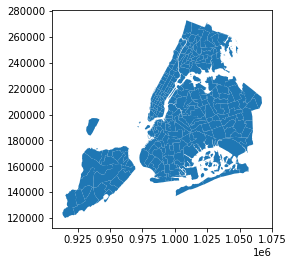

In [98]:
zones.geometry.plot();

Replace each polygon with its centroid to get Points instead of Polygons:

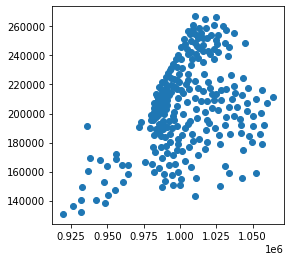

In [99]:
zones_pts = zones.copy()
zones_pts.geometry = zones_pts.geometry.centroid
zones_pts.geometry.plot();

This is clearly a significant reduction in granularity. While the years 2009-2016 have precise latitude/longitude coordinates for each pickup and dropoff, the years 2017 and 2018 only have 236 pickup/dropoff points (the centroids of the Taxi Zones). This is not optimal, of course, but it's what we've got. 

To achieve consistency over the entire 10-year dataset, you decide to adopt the Taxi Zone as your spatial scale of analysis. This means that you will lose some granularity for the years 2009-2016 at the cost of consistency and comparability over all the years in your dataset. To achieve this, you'll have to join each trip record with Point data (2009-2016) to the Taxi Zone it is located within.

We'll be using the map_partitions method to perform our spatial join. This method allows you to map any Python function over all of the partitions in a Dask DataFrame. The function that is passed to map_partitions should take a pandas DataFrame as input, since each Dask DataFrame partition is a pandas DataFrame. Read more about map_partitions in the Mapping Custom Functions section of Chapter 4.

Let’s build this up step-by-step. We’ll start by writing code that will join the Taxi Zones Polygons to the corresponding trip records within a single pandas dataframe (i.e. Dask partition). Once we have that code working we can then pass it to map_partitions to map it over all of the partitions in our Dask DataFrame ddf that contains all of the 868 million taxi trips.

Start by creating a pandas DataFrame test_df to test our function:

In [11]:
test_df = ddf.partitions[0].compute()

In [12]:
len(test_df)

361207

Then turn this sample pandas DataFrame containing just over 361000 rows of data into a GeoDataFrame:

In [13]:
from shapely.geometry import Point

local_gdf = gpd.GeoDataFrame(
    test_df,
    crs="EPSG:4326",
    geometry=[
        Point(xy) for xy in zip(test_df["pickup_longitude"], test_df["pickup_latitude"])
    ],
)

You're now ready to perform the spatial join. Pass the two GeoDataFrames you want to join to gpd.sjoin() and specify the "within" predicate to join Points in the left DataFrame to Polygons they are located within in the right DataFrame:

In [14]:
joined = gpd.sjoin(
    local_gdf,
    shape_df,
    how="left",
    predicate="within",
)

In [15]:
joined.head(3)

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.63        -73.991957        40.721567         -73.993803   
1           4.55        -73.982102        40.736290         -73.955850   
2          10.35        -74.002587        40.739748         -73.869983   

   dropoff_latitude payment_type  fare_amount  surcharge  tip_amount  \
0         40.695922         CASH          8.9        0.5        0.00   
1         40.768030       Credit         12.1        0.5        2.00   
2         40.770225       Credit         23.7        0.0        4.74   

   tolls_amount  total_amount                    geometry  index_right  \
0           0.0          9.40  POINT (-73.99196 40.72157)     213633.0   
1           0.0         14.60  POINT (-73.98210 40.73629)     237920.0   
2           0.0         28.44  POINT (-74.00259 40.73975)     238634.0   

          block_id  
0  360610036013000  
1  360610064002001  
2  360610077003000

Let's verify to make sure that the Point for the first row is indeed inside the polygon for block 360610036013000:

In [16]:
# get polygon geometries for entries with matching first block_id
poly = shape_df[shape_df.block_id == joined.block_id[0]].geometry

In [17]:
# get first polygon index
poly.index[0]

213633

In [18]:
# assert whether first point is in first polygon
joined.geometry[0].within(poly[poly.index[0]])

True

Great, this is working as expected. Let’s now scale this up to apply it over the entire ddf containing all 868 million data points.

Define a function that will take a pandas DataFrame as input, then map that function over all the partitions in our Dask DataFrame:

In [19]:
%%time
# send copy of shape_df to all workers in our cluster
client.scatter(shape_df)

CPU times: user 13.5 s, sys: 2.56 s, total: 16.1 s
Wall time: 6min 9s


<Future: finished, type: geopandas.geodataframe.GeoDataFrame, key: GeoDataFrame-b299806af8ad201c2f37029da79cb76d>

In [20]:
def assign_blocks(df, lon_var, lat_var, locid_var):

    import numpy as np
    from shapely.geometry import Point

    # make a copy since we will modify lats and lons
    localdf = df[[lon_var, lat_var]].copy()

    # missing lat lon info is indicated by nan. Fill with zero
    # which is outside New York shapefile.
    localdf[lon_var] = localdf[lon_var].fillna(value=0.0)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.0)

    # # read in blocks shapefile
    # shape_df = gpd.read_file("s3://coiled-datasets/dask-book/test/tl_2021_36_tabblock20.shp")
    # # select columns of interest only
    # shape_df = shape_df[["GEOID20", "geometry"]]
    # # rename block column
    # shape_df = shape_df.rename(columns={"GEOID20": "block_id"})
    # # cast to epsg coordinate system
    # shape_df = shape_df.to_crs(epsg=4326)

    try:
        local_gdf = gpd.GeoDataFrame(
            localdf,
            crs="EPSG:4326",
            geometry=[Point(xy) for xy in zip(localdf[lon_var], localdf[lat_var])],
        )

        local_gdf = gpd.sjoin(
            local_gdf,
            shape_df,
            how="left",
            predicate="within",
        )

        return local_gdf.block_id.rename(locid_var)

    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
        return series

Now we can map this function over all partitions:

In [21]:
import numpy as np

In [22]:
%%time
ddf["pickup_block"] = ddf.map_partitions(
    assign_blocks,
    "pickup_longitude",
    "pickup_latitude",
    "pickup_block",
    meta=("pickup_block", np.float64),
)

CPU times: user 4.36 s, sys: 915 ms, total: 5.27 s
Wall time: 6.29 s


In [23]:
ddf.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   
3       DDS 2009-01-01 20:52:58 2009-01-01 21:14:00                1   
4       DDS 2009-01-24 16:18:23 2009-01-24 16:24:56                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.63        -73.991957        40.721567         -73.993803   
1           4.55        -73.982102        40.736290         -73.955850   
2          10.35        -74.002587        40.739748         -73.869983   
3           5.00        -73.974267        40.790955         -73.996558   
4           0.40        -74.001580        40.719382         -74.008378   

   dropoff_latitude payment_type  fare_amount  surcharge  tip_amount  \
0         40.695922         CASH          8.9        0.5        0.00   
1         40.768030       Credit         12.1        0.5        2.00   
2         40.770225       Credit         23.7        0.0        4.74   
3         40.731849       CREDIT         14.9        0.5        3.05   
4         40.720350         CASH          3.7        0.0        0.00   

   tolls_amount  total_amount     pickup_block  
0           0.0          9.40  360610036013000  
1           0.0         14.60  360610064002001  
2           0.0         28.44  360610077003000  
3           0.0         18.45  360610179007002  
4           0.0          3.70  360610045001010

Excellent, we now have the corresponding City Block for each taxi pickup.

## 5. Visualize the Data to Get Insights
Having done your due diligence and ensured the dataset is clean, you're now eager to visualise the data and hopefully get some meaningful insights that will help your organisation along. 

### Basic Matplotlib Plots
You want to plot some graphs to get a sense of the patterns in the dataset. Let's start with a very straightforward example: is there a relationship between trip_distance and fare_amount?

Having worked in pandas for years, you're comfortable using matplotlib and write the code below to create a scatter plot of the two columns.

In [ ]:
ddf.plot(x="trip_distance", y="tip_amount", kind="scatter")

Dask does not support the straightforward .plot() functionality you're used to because Dask DataFrames typically contain million- or billion-point datasets. Visualizing all of these points on a single matplotlib graph does not produce meaningful graphics due to extreme overlay of datapoints.

Let's take a little detour to illustrate this point and drive it home.

We'll subset the Dask DataFrame to load just 0.1% of the data into a pandas DataFrame.

In [76]:
# subset 0.1% of the dataset
frac = 0.001
subset = ddf.sample(frac=frac).compute()

In [77]:
len(subset)

868399

This DataFrame contains over 868,000 data points.

Let's plot this on a normal, static matplotlib plot:

<AxesSubplot:xlabel='trip_distance', ylabel='fare_amount'>

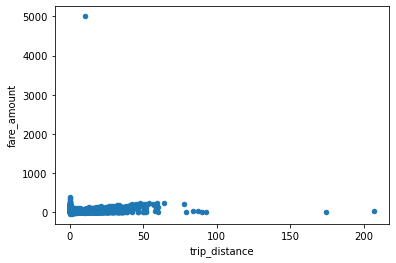

In [80]:
subset.plot(x="trip_distance", y="fare_amount", kind="scatter")

Or a little more involved to get a better formatted image:

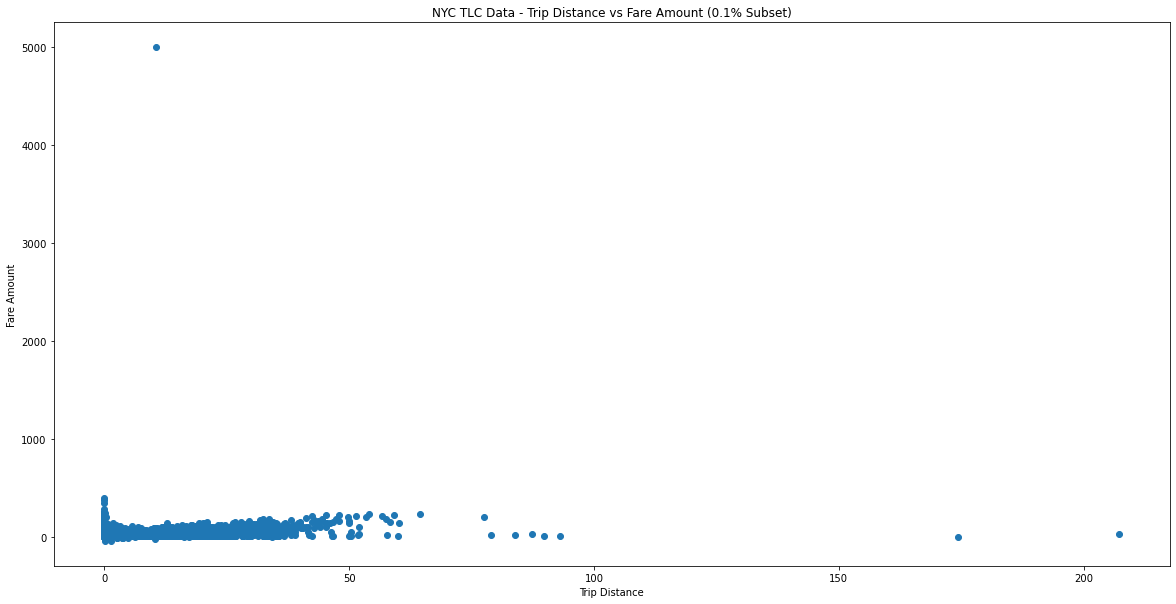

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[20, 10])
plt.scatter(
    subset["trip_distance"],
    subset["fare_amount"],
)
plt.title(f"NYC TLC Data - Trip Distance vs Fare Amount ({frac*100}% Subset)")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

The problem is pretty obvious: with this many data points it becomes impossible to distinguish individual data points when the density increases. There are literally hundreds of thousands of data points crammed into that bottom left corner. How many trips had a trip_distance of 20 miles and a fare_amount of 70? We simply can't tell from looking at this plot. 

And remember that this is only 0.1% of the dataset - there are 865 million more data points you would need to put on this graph to be complete!

You have two options here:
1. If you want to stick to using matplotlib or other standard plotting libraries, you'll have to reduce the number of data points even further. 
2. You can use DataShader to plot the entire dataset

### Plot Million-Point Datasets with DataShader
Datashader is an open-source Python library (part of the hvplot ecosystem) that was specifically developed for plotting million- and billion-point datasets. Rather than plotting a single point for each datapoint (which, as we have seen, quickly becomes unintelligble at this scale) Datashader instead uses a histogram method to create a color gradient that indicates the number of data points located on the same pixel. Generally speaking, darker pixels indicated less data points and lighter pixels indicate locations with higher density of data points.

For example, here's a datashader plot of all 300 million people in the US based on the 2010 census:

![image.png](attachment:cd1188e3-3c7b-4633-b44d-6d95faf3342d.png)

Fun fact: Datashader was built to work directly with Dask DataFrames.

#### Basic Datashader (Static)

Now that you've discovered Datashader, you're excited to try it out on your 868 million NYC TLC data points.

You import datashader, 

**NOTES**:
- datashader can't handle UInt8 and float16 it seems

## NEED TO CONVERT LOCATION DATA TO WEB MERCATOR!

### Undersampling Bokeh Plot

import holoviews as hv
import numpy as np
from holoviews import opts
from holoviews.element.tiles import StamenTonerBackgroundRetina

hv.extension("bokeh")

In [34]:
plot_width = int(750)
plot_height = int(plot_width // 1.2)
x_range, y_range = (-74.1, -73.7), (40.6, 40.9)
plot_options = hv.Options(width=plot_width, height=plot_height, xaxis=None, yaxis=None)

In [16]:
opts.defaults(
    opts.Points(width=plot_width, height=plot_height, size=5, color="blue"),
    opts.Overlay(width=plot_width, height=plot_height, xaxis=None, yaxis=None),
    opts.RGB(width=plot_width, height=plot_height),
)

In [36]:
samples_10k = ddf.sample(frac=0.00001).compute()
samples_1k = samples_10k.sample(n=1000)

In [130]:
len(samples_1k)

1000

In [170]:
tiles = StamenTonerBackgroundRetina().redim.range(x=x_range, y=y_range)
points = hv.Points(samples_1k, ["dropoff_longitude", "dropoff_latitude"])
tiles * points

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [dropoff_longitude,dropoff_latitude]   (vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount)

This lets us distinguish individual data points. But we are working with just over 0.0001% of the dataset. Not really a meaningful subset in any way.

### Oversampling: 10,000 data points (0.001%)

In [ ]:
samples_10k = ddf.sample(frac=0.00001).compute()

In [ ]:
len(samples)

9249

In [35]:
samples = ddf.sample(frac=0.00001).compute()
tiles = StamenTerrain().redim.range(x=x_range, y=y_range)
points = hv.Points(samples, ["dropoff_longitude", "dropoff_latitude"])
(tiles * points)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [dropoff_longitude,dropoff_latitude]   (vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount)

This is just .001 percent of the dataset. This means you are missing 99.999% of the datapoints (!)

Not acceptable.

### Plot all datapoints with Datashader

In [124]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9, Hot

Greys9_r = list(reversed(Greys9))[:-2]

In [125]:
%%time
cvs = ds.Canvas(
    plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range
)
agg = cvs.points(
    ddf, "dropoff_longitude", "dropoff_latitude", ds.count("passenger_count")
)
img = tf.shade(agg, cmap=["white", "darkblue"], how="linear")

CPU times: user 36.3 s, sys: 1.35 s, total: 37.6 s
Wall time: 3min 23s


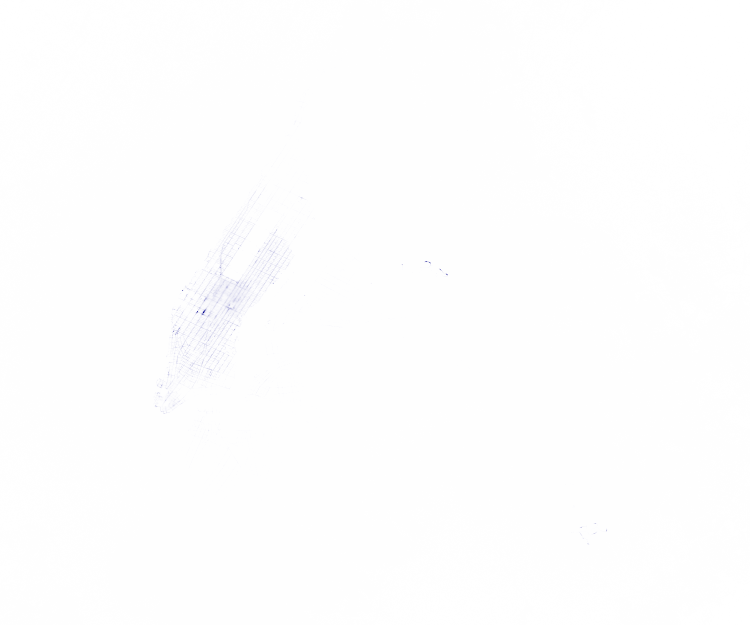

In [126]:
img

Non-linear scaling:

In [127]:
img2 = tf.shade(agg, cmap=Greys9_r, how="log")

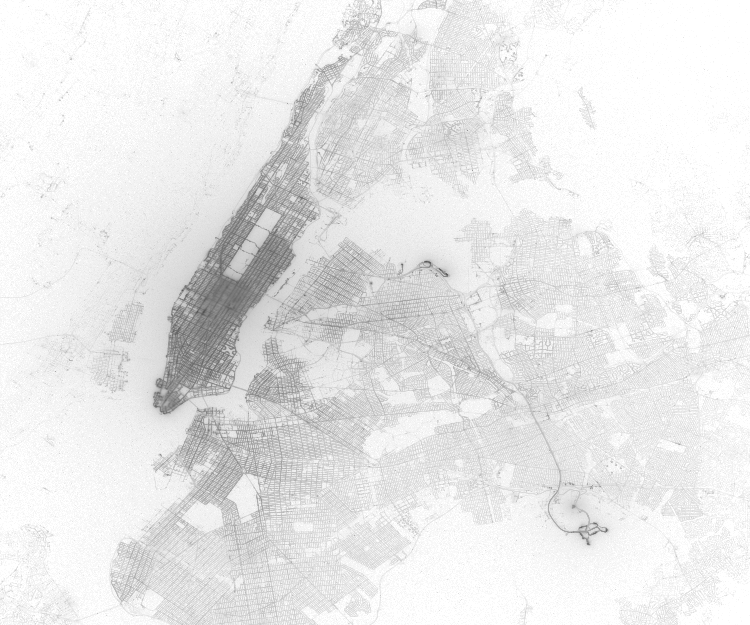

In [128]:
img2

**note to self**: Interesting, it looks like creating the `agg` object is what takes the biggest chunk of time here. After that, creating subsequent images is almost instant. I wonder if persisting `ddf` before creating the `agg` object would make this even faster.

CPU times: user 65.1 ms, sys: 10.6 ms, total: 75.8 ms
Wall time: 76.4 ms


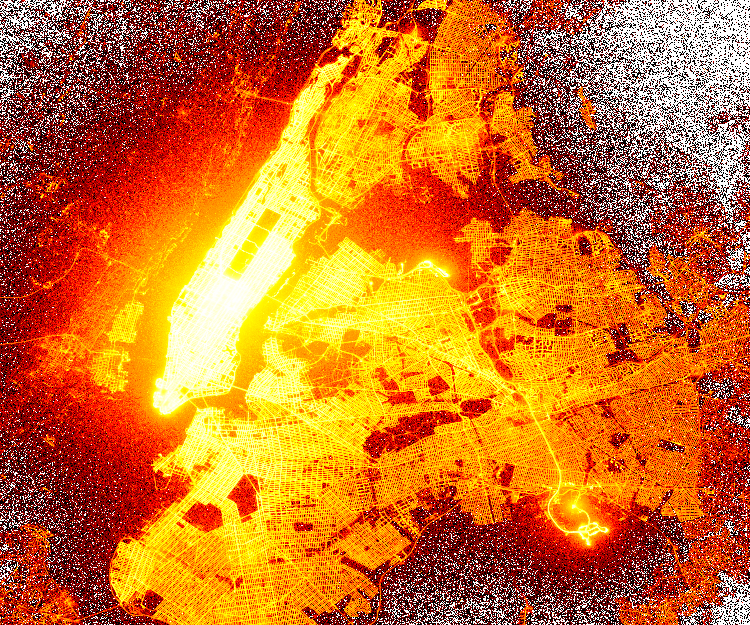

In [129]:
%%time
img3 = tf.shade(agg, cmap=Hot, how="eq_hist")
img3

### Datashader for Non-geographical Data
You can also use Datashader to plot non-geographical data. For example, you're interested in XX vs YY:

In [51]:
ddf.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   
3       DDS 2009-01-01 20:52:58 2009-01-01 21:14:00                1   
4       DDS 2009-01-24 16:18:23 2009-01-24 16:24:56                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.63        -73.991957        40.721567         -73.993803   
1           4.55        -73.982102        40.736290         -73.955850   
2          10.35        -74.002587        40.739748         -73.869983   
3           5.00        -73.974267        40.790955         -73.996558   
4           0.40        -74.001580        40.719382         -74.008378   

   dropoff_latitude payment_type  fare_amount  surcharge  tip_amount  \
0         40.695922         CASH          8.9        0.5        0.00   
1         40.768030       Credit         12.1        0.5        2.00   
2         40.770225       Credit         23.7        0.0        4.74   
3         40.731849       CREDIT         14.9        0.5        3.05   
4         40.720350         CASH          3.7        0.0        0.00   

   tolls_amount  total_amount  
0           0.0          9.40  
1           0.0         14.60  
2           0.0         28.44  
3           0.0         18.45  
4           0.0          3.70

In [54]:
ddf.trip_distance.max().compute(), ddf.fare_amount.max().compute()

(16201631.4, 158995.81)

In [62]:
%%time
cvs = ds.Canvas(
    plot_width=plot_width, plot_height=plot_height, x_range=(0, 200), y_range=(0, 300)
)

agg = cvs.points(ddf, "trip_distance", "fare_amount", ds.count("passenger_count"))
img = tf.shade(agg, cmap=["white", "darkblue"], how="linear")

CPU times: user 18.4 ms, sys: 4.16 ms, total: 22.6 ms
Wall time: 21.5 ms


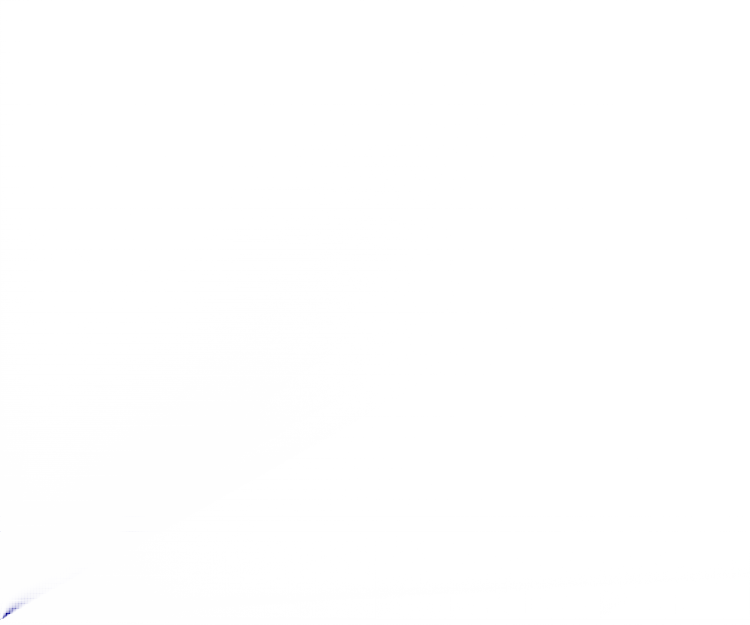

In [58]:
img

In [60]:
from datashader.colors import Hot

CPU times: user 113 ms, sys: 44.5 ms, total: 157 ms
Wall time: 156 ms


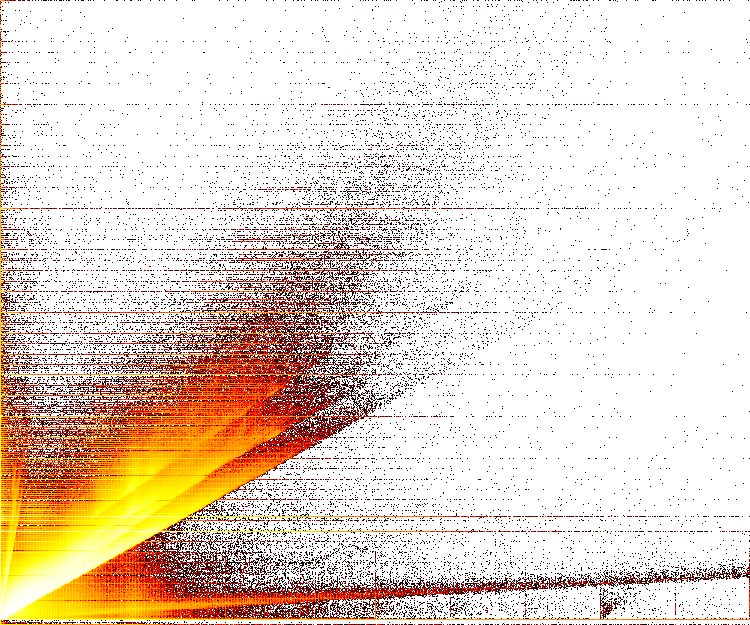

In [65]:
%%time
img3 = tf.shade(
    agg,
    cmap=Hot,
    how="eq_hist",
    name="trip_distance VS fare_amount",
)
img3

### Interactive Datashader

In [46]:
# import holoviews.operation.datashader as hd
# from datashader.colors import Hot
# shaded = hd.datashade(hv.Points(ddf, ['dropoff_longitude', 'dropoff_latitude']), cmap=Hot, aggregator=ds.count('passenger_count'))
# hd.dynspread(shaded, threshold=0.5, max_px=4).opts(bgcolor='black', xaxis=None, yaxis=None, width=900, height=500)

:DynamicMap   []
   :RGB   [dropoff_longitude,dropoff_latitude]   (R,G,B,A)

This doesn't seem very meaningful. I think we'd better go for the .inspect() option.

In [73]:
samples_10k = ddf.sample(frac=0.00001)

In [74]:
len(samples_10k)

9249

In [79]:
import colorcet
import panel as pn

In [89]:
x_range, y_range

((-74.1, -73.7), (40.6, 40.9))

In [120]:
import holoviews as hv

esri = (
    hv.element.tiles.ESRI()
    .redim(x="longitude", y="latitude")
    .opts(xlim=(-7.41e6, -7.37e6), ylim=(4.06e6, 4.09e6))
)
esri

:Tiles   [longitude,latitude]

In [121]:
points = hv.Points(samples_10k, kdims=["dropoff_longitude", "dropoff_latitude"])
raster = hv.operation.datashader.rasterize(points).opts(
    cnorm="eq_hist", cmap=colorcet.CET_L4[::-1], responsive=True, colorbar=True
)
highlight = hv.operation.datashader.inspect(raster).opts(
    marker="o", size=10, fill_alpha=0, color="white", tools=["hover"]
)
overlay = esri * raster.opts(cmap="fire", cnorm="eq_hist", min_height=400) * highlight
description = """
This dashboard shows how easy it is to go from an aggregate view of 2.4 million points
down to the details of a single GPS sample.
"""
pn.Column(
    "## Gull tracking dashboard", description, sizing_mode="stretch_both"
).servable()

Column(sizing_mode='stretch_both')
    [0] Markdown(str)
    [1] Markdown(str)

In [122]:
raster

:DynamicMap   []
   :Image   [dropoff_longitude,dropoff_latitude]   (dropoff_longitude_dropoff_latitude Count)

## 6. Join Multiple Datasets for Better Insights
Remember: you’ve been tasked with analyzing patterns in the locations of taxi dropoffs and pickups and geographic indicators of public health measures at the city-block level. You have one half of this equation – the TLC data – and are now in a good position to join this cleaned data to the demographic data at block level.


In [3]:
import dask.dataframe as dd

ddf = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009-2013",
    engine="pyarrow",
)

In [4]:
ddf.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   
3       DDS 2009-01-01 20:52:58 2009-01-01 21:14:00                1   
4       DDS 2009-01-24 16:18:23 2009-01-24 16:24:56                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.63        -73.991957        40.721567         -73.993803   
1           4.55        -73.982102        40.736290         -73.955850   
2          10.35        -74.002587        40.739748         -73.869983   
3           5.00        -73.974267        40.790955         -73.996558   
4           0.40        -74.001580        40.719382         -74.008378   

   dropoff_latitude payment_type  fare_amount  surcharge  tip_amount  \
0         40.695922         CASH          8.9        0.5        0.00   
1         40.768030       Credit         12.1        0.5        2.00   
2         40.770225       Credit         23.7        0.0        4.74   
3         40.731849       CREDIT         14.9        0.5        3.05   
4         40.720350         CASH          3.7        0.0        0.00   

   tolls_amount  total_amount  
0           0.0          9.40  
1           0.0         14.60  
2           0.0         28.44  
3           0.0         18.45  
4           0.0          3.70

In [5]:
ddf = ddf.repartition(partition_size="100MiB").persist()

### Perform Spatial Join
Your demographic data is at the city block level. This mean you'll first have to join the taxi trip records to a dataset containing the polygons that define the New York city blocks. This will allow you to determine in which Block taxi pickups and dropoffs were located. This is referred to as a "spatial join" and we'll be using the geopandas and dask-geopandas packages to do so.

[Geopandas](https://geopandas.org/en/stable/) is a Python package that extends the datatypes used by pandas to allow spatial operations on geometric types. You can, for example, perform joins on columns containing Points and Polygons respectively, and specifying that you want Points to be joined to the Polygons in which they are located using the "within" keyword. This is precisely what we'll be doing below.

Dask-geopandas scales Geopandas to larger-than-memory datasets using out-of-core computations. Since GeoPandas is an extension to the pandas DataFrame, the same way Dask scales pandas can also be applied to GeoPandas.

Let's build this workflow up step by step so you can follow along and gain a deep understanding of what's going on.

You'll start by importing geopandas and loading into a Geopandas DataFrame the .shp file that contains the geometric information (polygons) that define the New York City blocks:

In [7]:
import geopandas as gpd

shape_df = gpd.read_file(
    "/Users/rpelgrim/Desktop/data/nyc/nyc-blocks-shapefiles/tl_2021_36_tabblock20.shp"
)

In [8]:
type(shape_df)

geopandas.geodataframe.GeoDataFrame

Then subset the GeoDataFrame to use only the columns of interest: the unique block ID and the polygon geometries. Let's also rename the block ID column for clarity and specify the Coordinate Reference System:

In [9]:
shape_df = shape_df[["GEOID20", "geometry"]]
shape_df = shape_df.rename(columns={"GEOID20": "block_id"})
shape_df = shape_df.to_crs(epsg=4326)
shape_df

block_id                                           geometry
0       360894925011010  POLYGON ((-75.18319 44.28512, -75.18317 44.285...
1       360894926002022  POLYGON ((-75.22187 44.35886, -75.22181 44.358...
2       360894926002034  POLYGON ((-75.24227 44.35962, -75.24224 44.359...
3       360894926002029  POLYGON ((-75.22892 44.34260, -75.22824 44.345...
4       360894926002010  POLYGON ((-75.20348 44.34664, -75.20298 44.346...
...                 ...                                                ...
288814  360290091091003  POLYGON ((-78.76818 42.99130, -78.76790 42.991...
288815  360290080024000  POLYGON ((-78.85313 42.98686, -78.85299 42.986...
288816  360290150021039  POLYGON ((-78.50801 42.74905, -78.50800 42.749...
288817  360290154021007  POLYGON ((-78.97053 42.71551, -78.97043 42.715...
288818  360290175022047  POLYGON ((-78.82569 42.49155, -78.82509 42.491...

[288819 rows x 2 columns]

GeoDataFrames have a .plot() method that will plot the contents of the geometry column. This will let you visualize all the NY blocks together:

<AxesSubplot:>

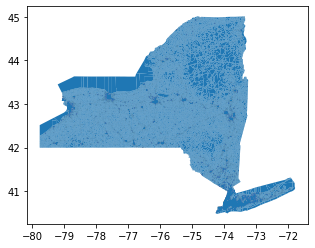

In [10]:
shape_df.plot()

### Join Demographic Data

You're now in a good position to join the demographic data at the block level to your Dask DataFrame.

## NOTES TO SELF

- clean demographic data
  - use only columns with single race breakdown
  - give columns better names


### Notes about CHS Data
- zeroes are null data
- if varialbe_r = 1: unreliable
- if variable_s = 1: suppressed, should have no data
- `exercs2`: any physical activity in the last month
- `depres2`: history of depression
- `wkwork2`: Walked/biked more than 10 blocks as transportation in the past month

In [7]:
import geopandas as gpd

chs = gpd.read_file(
    "/Users/rpelgrim/Desktop/data/nyc/nyc-communityhealth-shapefiles/CHS_2009_DOHMH_2010B/CHS_2009_DOHMH_2010B.shp"
)
chs.head(3)

UHF34_CODE FIRST_BORO               FIRST_UHF_  UHF_CODE  UHF_Code_1  \
0       101.0      Bronx  Kingsbridge - Riverdale     101.0       101.0   
1       102.0      Bronx          Northeast Bronx     102.0       102.0   
2       103.0      Bronx     Fordham - Bronx Park     103.0       103.0   

   asthev2  asthev2_r  asthev2_s  bmicat3  bmicat3_r  ...  sugarb3_s  waters5  \
0     13.4        0.0        0.0     18.7        0.0  ...        0.0     20.2   
1     14.7        0.0        0.0     25.6        0.0  ...        0.0     25.0   
2     16.9        0.0        0.0     28.3        0.0  ...        0.0     23.4   

   waters5_r  waters5_s  wkwork2  wkwork2_r  wkwork2_s    SHAPE_Leng  \
0        0.0        0.0     65.5        0.0        0.0  57699.155285   
1        0.0        0.0     61.9        0.0        0.0  88219.317097   
2        0.0        0.0     60.5        0.0        0.0  59711.872581   

     SHAPE_Area                                           geometry  
0  1.332914e+08  POLYGON ((1017992.893 269222.964, 1017812.000 ...  
1  1.813708e+08  POLYGON ((1025012.990 270794.260, 1025061.481 ...  
2  1.407724e+08  POLYGON ((1023994.479 261065.967, 1023885.806 ...  

[3 rows x 80 columns]

<AxesSubplot:>

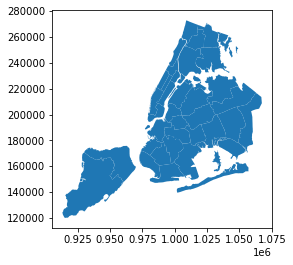

In [8]:
chs.geometry.plot()

In [9]:
chs.columns

Index(['UHF34_CODE', 'FIRST_BORO', 'FIRST_UHF_', 'UHF_CODE', 'UHF_Code_1',
       'asthev2', 'asthev2_r', 'asthev2_s', 'bmicat3', 'bmicat3_r',
       'bmicat3_s', 'bphigh2', 'bphigh2_r', 'bphigh2_s', 'bpmeds2',
       'bpmeds2_r', 'bpmeds2_s', 'cndmal2', 'cndmal2_r', 'cndmal2_s',
       'cotest2', 'cotest2_r', 'cotest2_s', 'depres2', 'depres2_r',
       'depres2_s', 'diabet2', 'diabet2_r', 'diabet2_s', 'exercs2',
       'exercs2_r', 'exercs2_s', 'flusht2', 'flusht2_r', 'flusht2_s',
       'fruitv3', 'fruitv3_r', 'fruitv3_s', 'genhlt4', 'genhlt4_r',
       'genhlt4_s', 'hivtes3', 'hivtes3_r', 'hivtes3_s', 'insure5',
       'insure5_r', 'insure5_s', 'mamtwo2', 'mamtwo2_r', 'mamtwo2_s',
       'nomedc2', 'nomedc2_r', 'nomedc2_s', 'papthe2', 'papthe2_r',
       'papthe2_s', 'pcarep2', 'pcarep2_r', 'pcarep2_s', 'rdrink2',
       'rdrink2_r', 'rdrink2_s', 'rsmoke3', 'rsmoke3_r', 'rsmoke3_s',
       'sfhnon2', 'sfhnon2_r', 'sfhnon2_s', 'sugarb3', 'sugarb3_r',
       'sugarb3_s', 'waters5', 'w

In [10]:
health = chs[["FIRST_UHF_", "UHF_CODE", "geometry", "wkwork2", "exercs2", "depres2"]]
health = health.rename(columns={"FIRST_UHF_": "nhbd_name", "UHF_CODE": "nhbd_id"})
health = health.to_crs(epsg=4326)

In [11]:
health.head(3)

nhbd_name  nhbd_id  \
0  Kingsbridge - Riverdale    101.0   
1          Northeast Bronx    102.0   
2     Fordham - Bronx Park    103.0   

                                            geometry  wkwork2  exercs2  \
0  POLYGON ((-73.87793 40.90556, -73.87859 40.903...     65.5     72.2   
1  POLYGON ((-73.85253 40.90985, -73.85235 40.909...     61.9     79.2   
2  POLYGON ((-73.85627 40.88315, -73.85666 40.882...     60.5     62.9   

   depres2  
0     15.6  
1     12.2  
2     13.8

### Spatial Join

In [12]:
%%time
client.scatter(health)

CPU times: user 32.7 ms, sys: 4.76 ms, total: 37.5 ms
Wall time: 3.7 s


<Future: finished, type: geopandas.geodataframe.GeoDataFrame, key: GeoDataFrame-4ae91e20d03462be45b37ce27c066a05>

In [13]:
test_df = ddf.partitions[0]

In [14]:
test_df = test_df.sample(frac=0.1).compute()

In [15]:
type(test_df)

pandas.core.frame.DataFrame

In [16]:
from shapely.geometry import Point

In [17]:
local_gdf = gpd.GeoDataFrame(
    test_df,
    crs="EPSG:4326",
    geometry=[
        Point(xy) for xy in zip(test_df["pickup_longitude"], test_df["pickup_latitude"])
    ],
)

local_gdf = gpd.sjoin(
    local_gdf,
    health,
    how="left",
    predicate="within",
)

local_gdf

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
142446       CMT 2009-01-22 04:49:24 2009-01-22 05:06:11                1   
311191       VTS 2009-01-25 05:56:00 2009-01-25 06:04:00                1   
353282       CMT 2009-01-14 14:44:54 2009-01-14 14:56:27                1   
247213       CMT 2009-01-23 02:13:12 2009-01-23 02:20:01                1   
347041       CMT 2009-01-28 13:51:29 2009-01-28 14:00:50                1   
...          ...                 ...                 ...              ...   
29483        VTS 2009-01-18 11:29:00 2009-01-18 11:34:00                2   
357686       CMT 2009-01-16 19:27:29 2009-01-16 19:37:33                1   
2253         CMT 2009-01-25 13:28:34 2009-01-25 13:29:36                1   
300150       CMT 2009-01-27 18:43:49 2009-01-27 18:47:57                1   
136548       CMT 2009-01-11 17:17:56 2009-01-11 17:26:21                2   

        trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
142446           7.20        -74.005438        40.740821         -73.942775   
311191           3.33        -73.980540        40.750992         -73.946242   
353282           1.90        -73.986366        40.751680         -74.008065   
247213           1.70        -74.002602        40.749986         -73.977549   
347041           1.90        -73.959095        40.777585         -73.978874   
...               ...               ...              ...                ...   
29483            0.70        -73.960678        40.767425         -73.954152   
357686           1.10        -73.982410        40.768315         -73.983315   
2253             0.30        -73.988447        40.733945         -73.987986   
300150           0.90        -73.989658        40.741402         -73.993787   
136548           1.50        -73.994270        40.764098         -73.971236   

        dropoff_latitude payment_type  ...  tip_amount  tolls_amount  \
142446         40.830659       Credit  ...        2.00           0.0   
311191         40.783850       Credit  ...        1.80           0.0   
353282         40.738296         Cash  ...        0.00           0.0   
247213         40.747203         Cash  ...        0.00           0.0   
347041         40.760156       Credit  ...        3.00           0.0   
...                  ...          ...  ...         ...           ...   
29483          40.764042         CASH  ...        0.00           0.0   
357686         40.755581       Credit  ...        1.58           0.0   
2253           40.733699    No Charge  ...        0.00           0.0   
300150         40.731321         Cash  ...        0.00           0.0   
136548         40.752539         Cash  ...        0.00           0.0   

        total_amount                    geometry  index_right  \
142446         20.20  POINT (-74.00544 40.74082)         28.0   
311191         12.00  POINT (-73.98054 40.75099)         27.0   
353282          8.10  POINT (-73.98637 40.75168)         28.0   
247213          7.40  POINT (-74.00260 40.74999)         28.0   
347041         11.20  POINT (-73.95910 40.77759)         27.0   
...              ...                         ...          ...   
29483           4.50  POINT (-73.96068 40.76743)         27.0   
357686          9.48  POINT (-73.98241 40.76832)         18.0   
2253            2.50  POINT (-73.98845 40.73394)         29.0   
300150          5.50  POINT (-73.98966 40.74140)         27.0   
136548          6.50  POINT (-73.99427 40.76410)         28.0   

                            nhbd_name   nhbd_id wkwork2  exercs2  depres2  
142446              Chelsea - Village  306308.0    85.8     88.3     21.5  
311191     Upper East Side - Gramercy  305307.0    85.0     85.9     14.8  
353282              Chelsea - Village  306308.0    85.8     88.3     21.5  
247213              Chelsea - Village  306308.0    85.8     88.3     21.5  
347041     Upper East Side - Gramercy  305307.0    85.0     85.9     14.8  
...                            

In [18]:
import numpy as np

In [19]:
def join_health_data(df, lon_var, lat_var):

    # make a copy since we will modify lats and lons
    localdf = df.copy()

    # missing lat lon info is indicated by nan. Fill with zero
    # which is outside New York shapefile.
    localdf[lon_var] = localdf[lon_var].fillna(value=0.0)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.0)

    # # read in blocks shapefile
    # shape_df = gpd.read_file("s3://coiled-datasets/dask-book/test/tl_2021_36_tabblock20.shp")
    # # select columns of interest only
    # shape_df = shape_df[["GEOID20", "geometry"]]
    # # rename block column
    # shape_df = shape_df.rename(columns={"GEOID20": "block_id"})
    # # cast to epsg coordinate system
    # shape_df = shape_df.to_crs(epsg=4326)

    try:
        local_gdf = gpd.GeoDataFrame(
            localdf,
            crs="EPSG:4326",
            geometry=[Point(xy) for xy in zip(localdf[lon_var], localdf[lat_var])],
        )

        local_gdf = gpd.sjoin(
            local_gdf,
            health,
            how="left",
            predicate="within",
        )

        return local_gdf

    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
        return series

**NOTE TO SELF:** might want to repartition before calling this `map_partitions`

In [20]:
%%time
joined = ddf.map_partitions(
    join_health_data,
    "pickup_longitude",
    "pickup_latitude",
)

CPU times: user 30.4 ms, sys: 2.52 ms, total: 32.9 ms
Wall time: 30.9 ms


In [21]:
joined.head(3)

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.63        -73.991957        40.721567         -73.993803   
1           4.55        -73.982102        40.736290         -73.955850   
2          10.35        -74.002587        40.739748         -73.869983   

   dropoff_latitude payment_type  ...  tip_amount  tolls_amount  total_amount  \
0         40.695922         CASH  ...        0.00           0.0          9.40   
1         40.768030       Credit  ...        2.00           0.0         14.60   
2         40.770225       Credit  ...        4.74           0.0         28.44   

                     geometry  index_right                      nhbd_name  \
0  POINT (-73.99196 40.72157)         29.0  Union Square, Lower Manhattan   
1  POINT (-73.98210 40.73629)         27.0     Upper East Side - Gramercy   
2  POINT (-74.00259 40.73975)         28.0              Chelsea - Village   

    nhbd_id wkwork2  exercs2  depres2  
0  309310.0    73.8     79.0     12.4  
1  305307.0    85.0     85.9     14.8  
2  306308.0    85.8     88.3     21.5  

[3 rows x 22 columns]

In [22]:
health.wkwork2.min(), health.wkwork2.max()

(0.0, 88.1)

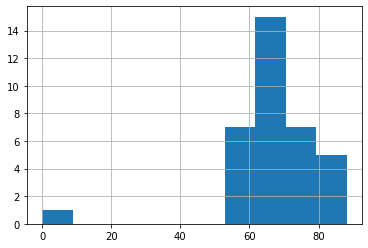

In [23]:
health.wkwork2.hist();

In [25]:
joined.head()

AttributeError: 'Future' object has no attribute 'copy'

## RESEARCH QUESTIONS:

- Predict tip_amount to drive a campaign to motivate drivers towards high-tip trips: can we predict tip_amount based on pickup/dropoff location (city block), passenger_count, payment_type, trip_distance, fare_amount.
  - only TLC data
  - 
  
  
- Report to Public Health Department about possible correlations between number of taxi pickups in a neighbourhood and that neighbourhood's physical activity and mental health indicators.
  - spatial join to get pickup neighbourhoods 
  - aggregate (count) trips per pickup neighbourhood
  - aggregate (mean) trip_distance per pickup neighbourhood
  - aggregate (mean) tip_amount per pickup neighbourhood


#### Personal Notes
Spatial join to get borough names. Join to socioeconomic/racial/... data at borough level.

A shapefile for mapping data by Modified Zip Code Tabulation Areas (MODZCTA) in NYC: https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-/pri4-ifjk

Borough shapefile: https://geo.nyu.edu/catalog/nyu-2451-34510



NYC Mental Health Survey (telephone) conducted in 2012: https://data.cityofnewyork.us/Health/DOHMH-Community-Mental-Health-Survey/wi3r-8uzb

NYC Community HEalth Survey (telephone) conducted in 2022: https://data.cityofnewyork.us/Health/New-York-City-Community-Health-Survey/csut-3wpr

More health data: https://a816-health.nyc.gov/hdi/epiquery/visualizations?PageType=ps&PopulationSource=CHSl

Read more about the Best Practices and specific performance considerations of performing joins in the How to Work with Dask DataFrames chapter.


- geopandas is being finicky with getting `fiona` installed
- trying spatial pandas now

### Spatial Pandas

1. Turn pick_up and drop_off lat/long into PointArray columns (might need to split pick_up and drop_off into separate df's. Or use LineArray instead)
2. Create columns: Borough_start and Borough_end
3. Join to dataframe with socioeconomic indicators by borough

resources:
- https://nbviewer.org/github/holoviz/spatialpandas/blob/master/examples/Overview.ipynb
- https://github.com/holoviz/spatialpandas/blob/master/examples/Overview.ipynb
- https://github.com/holoviz/spatialpandas/issues/65 (to map PointArray over Dask DataFrame)

In [1]:
from spatialpandas.geometry import (
    LineArray,
    MultiLineArray,
    MultiPointArray,
    MultiPolygonArray,
    PointArray,
    PolygonArray,
)

In [3]:
from spatialpandas import GeoDataFrame, GeoSeries

In [ ]:
def to_gs(df):
    points = spd.geometry.PointArray((df[""], df["y"]))
    spgs = spd.GeoSeries(points, index=df.index)
    return GeoDataFrame(dict(position=spgs, **{col: df[col] for col in df.columns}))


spdgeom = df.map_partitions(to_gs)

### GeoPandas

1. install dask-geopandas
2. import borough shapefile

In [38]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [37]:
gpd.read_file(
    "/Users/rpelgrim/Desktop/data/nyc/ny-counties-census/tl_2021_36_cousub.shp"
)

NameError: name 'gpd' is not defined

In [20]:
gpd.read_file(
    "/Users/rpelgrim/Desktop/data/nyc/ny-counties-census/tl_2021_36_cousub.shp"
).to_crs({"init": "epsg:4326"}).plot(column="borough", categorical=True)

ImportError: the 'read_file' function requires the 'fiona' package, but it is not installed or does not import correctly.
Importing fiona resulted in: No module named 'fiona'

## 7. Train a Machine Learning Model on the Data
Now that you've explored the data and discovered some signal for a pattern between X and Y, you'd like to build a machine learning model that will test this relationship.

You want to predict the tip_amount based on the starting borough, trip_distance, etc.

from [here](https://xgboost.readthedocs.io/en/latest/tutorials/dask.html)

### Create train/test splits
We'll use the dask_ml library to create the train and test splits. Dask-ml is a library that scales the familiar scikit-learn API for running machine learning algorithms in parallel. Not every algorithm can be parallized, so dask-ml only supports a subset of the sklearn algorithms.

In [13]:
# create feature and target vectors
X = df[["passenger_count", "trip_distance", "fare_amount", "tolls_amount"]]
y = df["fare_amount"]

### Train the model

In [14]:
import xgboost as xgb

regressor = xgb.dask.DaskXGBRegressor(n_estimators=10, missing=0.0)

In [ ]:
%%time
regressor.client = client
regressor.set_params(tree_method="gpu_hist")
regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)])

## 8. Evaluate and Tune the Model

In [ ]:
# evaluate

In [18]:
from dask_ml.model_selection import GridSearchCV

In [ ]:
param_grid = {}

In [17]:
# set up grid-search CV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1)

## 8. Present the solution